<a href="https://colab.research.google.com/github/Sushmitha-Katti/Monocular-Depth-Estimation-and-Segmentation/blob/master/Both_Mask_n_Depth/MODEST_BCELOSS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Mask and Depth Prediction using BCE Loss for both but like transfer learning**
data is divided into 5 set of 80k images. Each trained seperately one after the other,next set trained from loading the best model from previous set.

# Check GPU type

In [1]:
!nvidia-smi

Wed May 27 03:59:15 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Mount Colab

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Extract

In [0]:
#Extract data
import time
import os
import zipfile
"""
Extract Data from Google drive
"""
def extract_data(no_of_set = 1):
    if(no_of_set > 6 or no_of_set < 1):
      print('No of sets should be not be less that 1 and greater that 6')
      return
    for i in range(1,no_of_set+1):
      start = time.time()
      if (os.path.isdir("data_"+str(i))):
          print (f'Imagesof set {i} already downloaded...')
      else:
        
        archive = zipfile.ZipFile(f'/content/gdrive/My Drive/Mask_Rcnn/Dataset/data_part{str(i)}.zip')
        archive.extractall()
      end = time.time()
    print(f"data set extraction took {round(end-start,2)}s")

    
extract_data(no_of_set=5)

data set extraction took 45.18s


# Clone Pynet

In [0]:
!git clone "https://github.com/Sushmitha-Katti/PyTNet"

Cloning into 'PyTNet'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (115/115), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 115 (delta 62), reused 76 (delta 30), pack-reused 0
Receiving objects: 100% (115/115), 34.01 KiB | 3.78 MiB/s, done.
Resolving deltas: 100% (62/62), done.


# Set 1

## Albumentation installation

In [0]:
!pip install --no-cache-dir git+https://github.com/albu/albumentations > /dev/null && echo "Albumentation library is successfully installed!"

  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-70leyl0y
Albumentation library is successfully installed!


In [0]:
import sys
sys.path.append("PyTNet")

## Import Statement

In [0]:
import torch
import train_test_loader
from Models.MaskDepthModel import UNet
import evaluate
from Albumentationtransform import AlbumentationTransforms

## Model Summary

In [0]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = UNet(n_channels = 6,n_classes = 1).to(device)
summary(model, input_size=(6, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]           1,760
       BatchNorm2d-2           [-1, 32, 64, 64]              64
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 32, 64, 64]           9,248
       BatchNorm2d-5           [-1, 32, 64, 64]              64
              ReLU-6           [-1, 32, 64, 64]               0
        DoubleConv-7           [-1, 32, 64, 64]               0
         MaxPool2d-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 32, 32, 32]           9,248
      BatchNorm2d-10           [-1, 32, 32, 32]              64
             ReLU-11           [-1, 32, 32, 32]               0
           Conv2d-12           [-1, 32, 32, 32]           9,248
      BatchNorm2d-13           [-1, 32, 32, 32]              64
             ReLU-14           [-1, 32,

## Dataloader and Albumentation

In [0]:
from Dataset.MaskDepth import RawDataSet
import albumentations as A
import cv2
import time
fg_bg_means = (0.65830478, 0.61511271, 0.5740604,0.65830478, 0.61511271, 0.5740604)
fg_bg_stdevs = (0.24408717, 0.2542491, 0.26870159,0.24408717, 0.2542491, 0.26870159)
op_means = (0)
op_std = (255)

train_transform = AlbumentationTransforms([       
                                                                
                             
                                      A.Resize(64,64),
                                      A.Normalize(mean=fg_bg_means, std=fg_bg_stdevs),
                                   
                                       ])
op_transform = AlbumentationTransforms([       
                                                                
                             
                                      A.Resize(64,64),
                                      A.Normalize(mean=op_means, std=op_std),
                                      A.Transpose(always_apply=True),
                                
                                   
                                       ])

test_transform = AlbumentationTransforms([
                                          A.Resize(64,64),
                                          A.Normalize(mean=fg_bg_means, std=fg_bg_stdevs),
                                        ])
train  = {
    'ip': train_transform,
    'op': op_transform
}
test = {
    'ip': test_transform,
    'op': op_transform
}
start = time.time()
train_dataset , test_dataset= RawDataSet(train_split = 70,test_transforms=test,train_transforms=train, set_no = 1,url = "/content/data_1" whole_data=False)
end = time.time()
print(f'dataset formation took {round(end-start,3)} seconds')


80000
dataset formation took 0.233 seconds


In [0]:
trainloader, testloader = train_test_loader.load(train_dataset,test_dataset,batch_size=128)

In [0]:
import torchvision
from torch.utils.tensorboard import SummaryWriter
tb = SummaryWriter('runs/MODEST-Depth-SSIM')
images, mask, depth = next(iter(trainloader))
images = images.to(device)

#tb.add_image('images', images)
tb.add_graph(model, images)
tb.close()

In [0]:
import os
logs_base_dir = "runs/MODEST-Depth-SSIM"
os.makedirs(logs_base_dir, exist_ok=True)

In [0]:
%reload_ext tensorboard
%tensorboard --logdir {logs_base_dir}

<IPython.core.display.Javascript object>

## Sample Inputs

sample train images took 1.449s to dispay


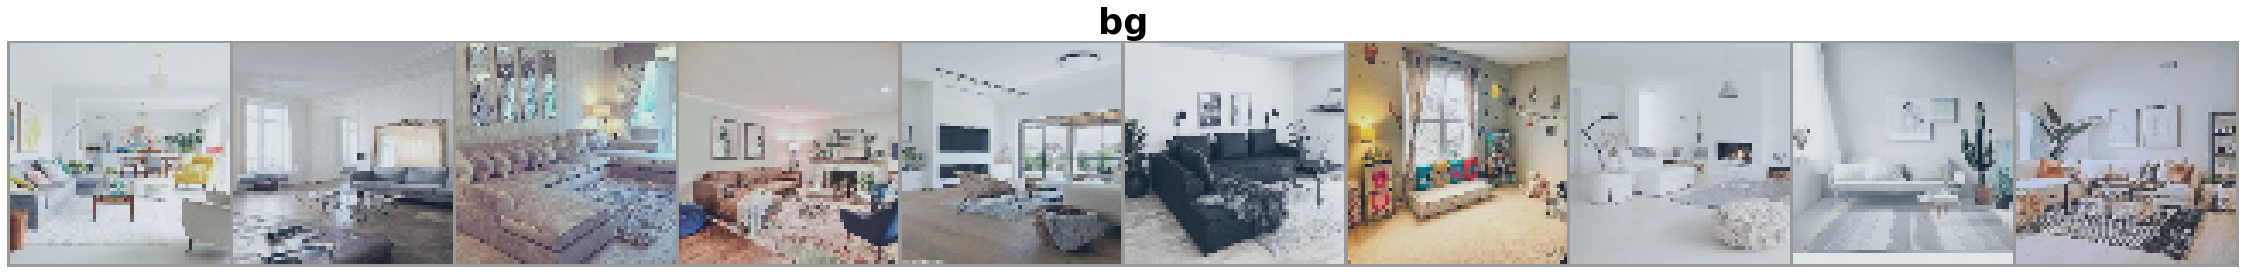

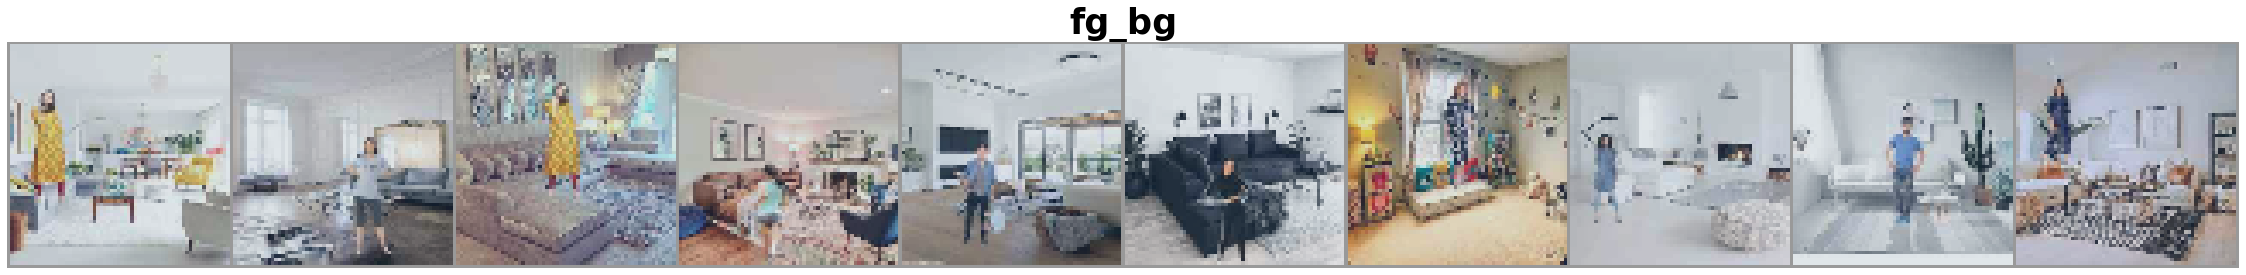

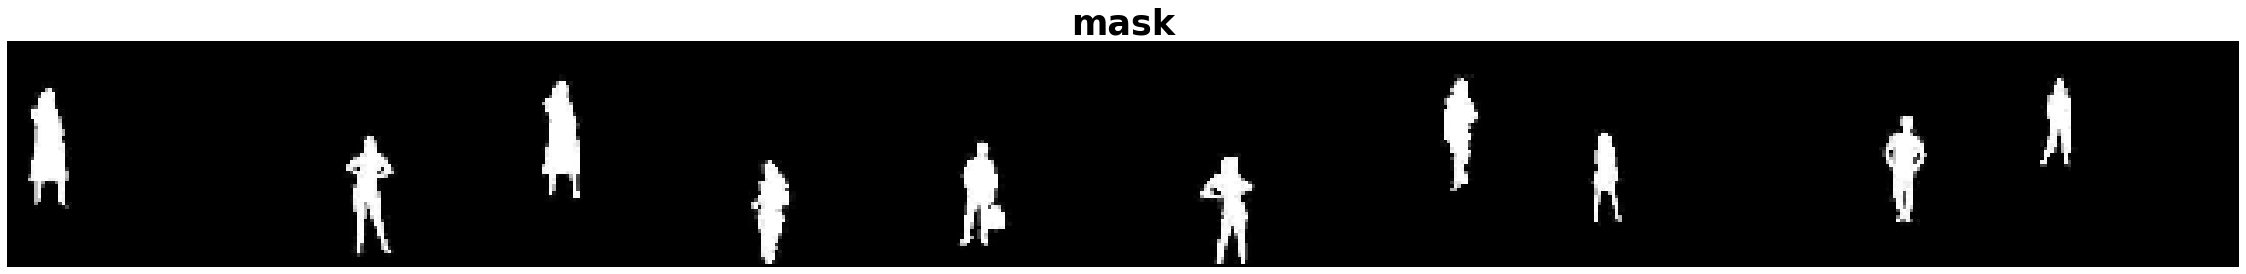

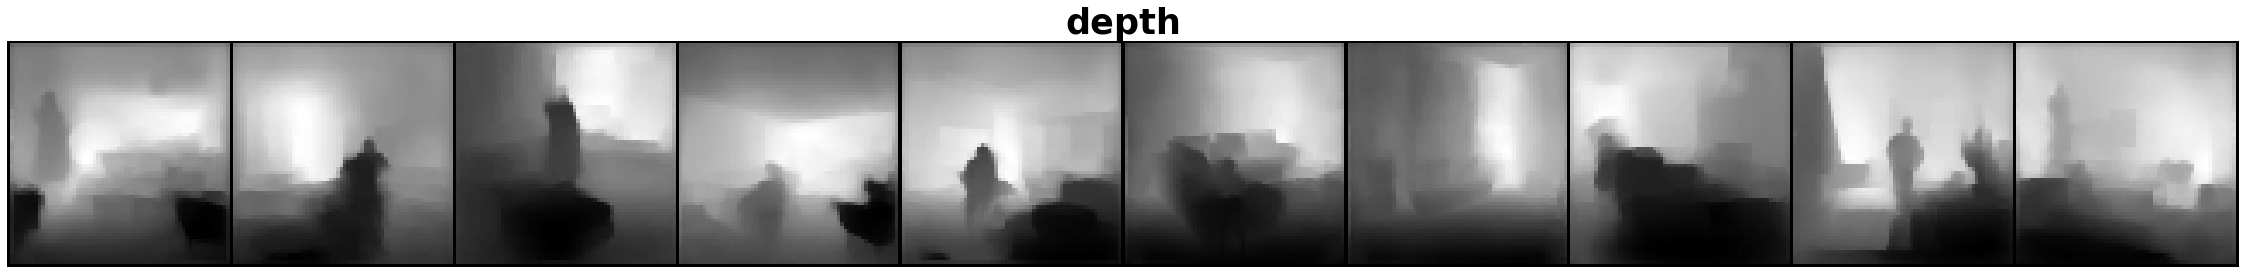

In [0]:
from show_images import show_sample_data
show_sample_data(trainloader)

## Optimiser and Loss Initialisation


In [0]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR,StepLR
import torchgeometry as tgm
model = UNet(n_channels = 6,n_classes = 1).to(device)
optimizer = optim.Adam(model.parameters(),lr=0.01)
scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min',patience=3, verbose=False)
#optimizer = optim.SGD(model.parameters(), lr=0.01,momentum=0.9,weight_decay = 0.0001,nesterov = True ) 

mask_criterion = nn.BCEWithLogitsLoss()
depth_criterion = tgm.losses.SSIM(5, reduction='mean')
#scheduler = OneCycleLR(optimizer, max_lr = 0.02, total_steps=None, epochs=10, steps_per_epoch=len(trainloader), pct_start=1/3, anneal_strategy='linear', cycle_momentum=True, base_momentum=0.85, max_momentum=0.95, div_factor=10.0,final_div_factor =10)


## Model Training

In [0]:
from Training.train_test_MnD import train_model
train_model(model,device,trainloader,testloader,optimizer,mask_criterion,depth_criterion,10,scheduler,batch_scheduler=False,best_loss = 999,path = "/content/gdrive/My Drive/S15-Checkpoints/checkpoint2.pt")

## Results

In [0]:
from Results.showMnd import show_results
show_results(model, testloader, "Results-1")

# Set 2

In [0]:
start = time.time()
train_dataset , test_dataset= RawDataSet(train_split = 70,test_transforms=test,train_transforms=train, set_no = 2,url_path ='/content/data_2', whole_data= False)
end = time.time()
print(f'dataset formation took {round(end-start,3)} seconds')


80000
dataset formation took 0.217 seconds


In [0]:
trainloader, testloader = train_test_loader.load(train_dataset,test_dataset,batch_size=128)

sample train images took 1.608s to dispay


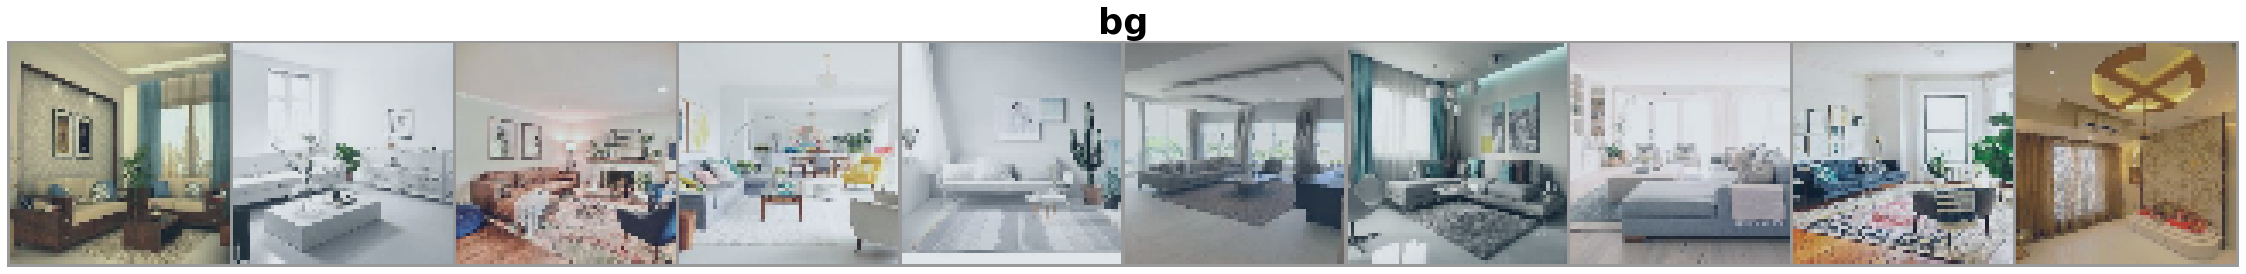

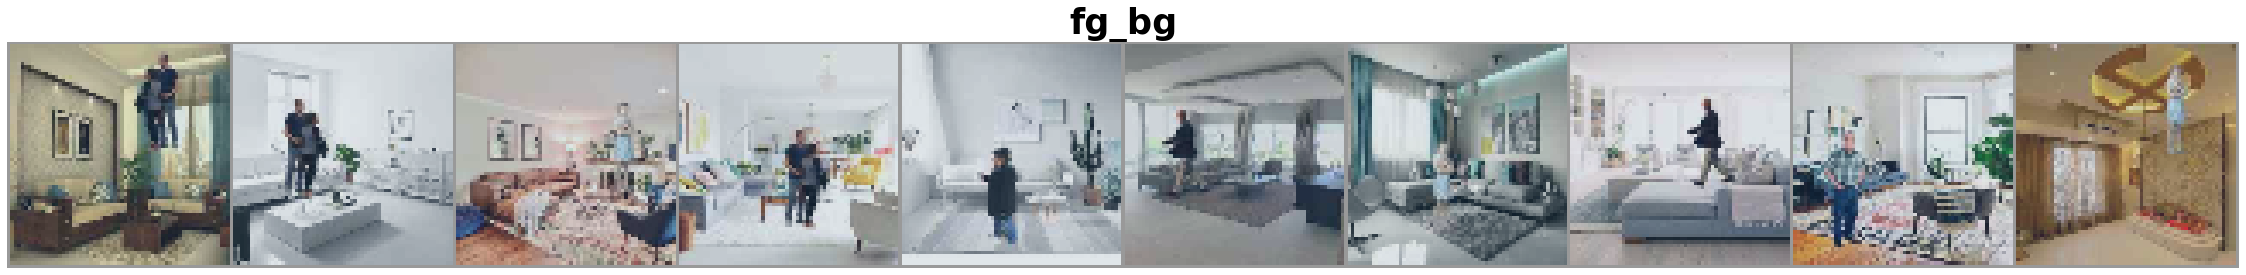

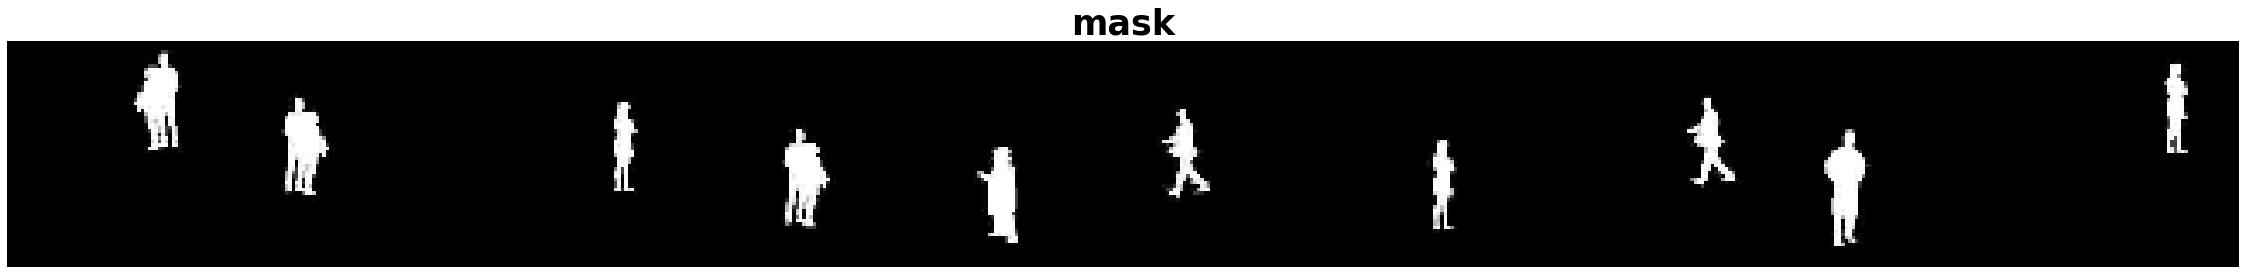

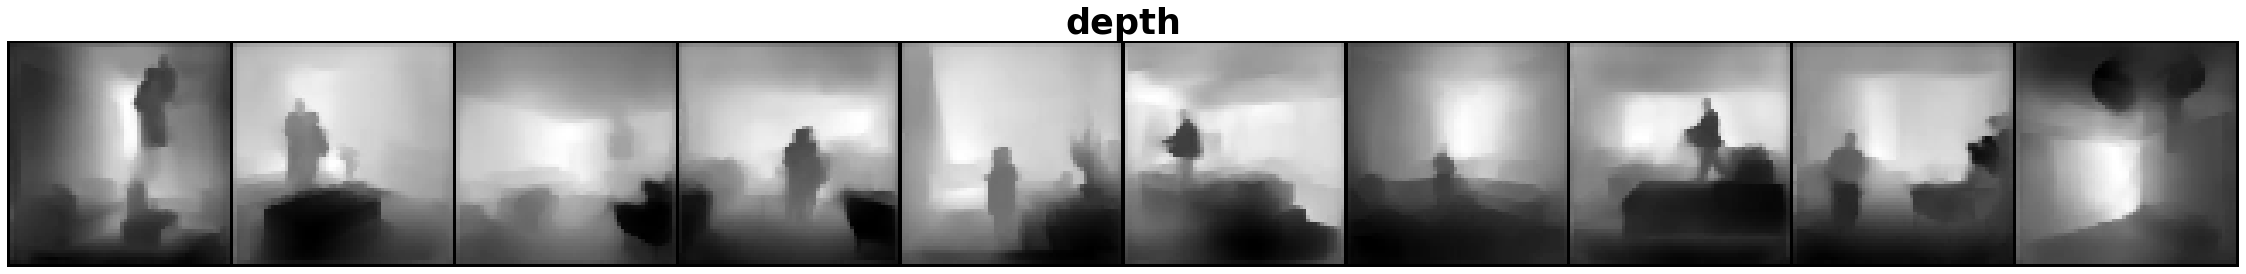

In [0]:
show_sample_data(trainloader)

In [0]:
model = UNet(n_channels = 6,n_classes = 1).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
checkpoint = torch.load("/content/gdrive/My Drive/S15-Checkpoints/checkpoint2.pt")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.eval()
print("Loaded the best model")

Loaded the best model


In [0]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR,StepLR
optimizer = optim.Adam(model.parameters(),lr=0.01)
scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience=2, verbose=False)

mask_criterion = nn.BCEWithLogitsLoss()
depth_criterion = nn.BCEWithLogitsLoss()


In [0]:
train_model(model,device,trainloader,testloader,optimizer,mask_criterion,depth_criterion,10,scheduler,batch_scheduler=False,best_loss = 0.0077,path = "/content/gdrive/My Drive/S15-Checkpoints/checkpoint2.pt")

EPOCH: 1 LR: 0.01




Train set: Average loss: 0.0075, Coef: (0.00289)





Test set: Average loss: 0.0076, Coef: (0.00300)

loss reduced, Saving model....
----------------------------------------------------------------------------------
EPOCH: 2 LR: 0.01




Train set: Average loss: 0.0077, Coef: (0.00303)





Test set: Average loss: 0.0076, Coef: (0.00303)

loss reduced, Saving model....
----------------------------------------------------------------------------------
EPOCH: 3 LR: 0.01




Train set: Average loss: 0.0079, Coef: (0.00300)





Test set: Average loss: 0.0076, Coef: (0.00252)

----------------------------------------------------------------------------------
EPOCH: 4 LR: 0.01




Train set: Average loss: 0.0076, Coef: (0.00297)





Test set: Average loss: 0.0076, Coef: (0.00295)

----------------------------------------------------------------------------------
EPOCH: 5 LR: 0.01




Train set: Average loss: 0.0075, Coef: (0.00303)





Test set: Average loss: 0.0076, Coef: (0.00308)

loss reduced, Saving model....
----------------------------------------------------------------------------------
EPOCH: 6 LR: 0.01




Train set: Average loss: 0.0075, Coef: (0.00305)





Test set: Average loss: 0.0076, Coef: (0.00305)

loss reduced, Saving model....
----------------------------------------------------------------------------------
EPOCH: 7 LR: 0.01




Train set: Average loss: 0.0075, Coef: (0.00306)





Test set: Average loss: 0.0076, Coef: (0.00309)

----------------------------------------------------------------------------------
EPOCH: 8 LR: 0.01




Train set: Average loss: 0.0073, Coef: (0.00307)





Test set: Average loss: 0.0076, Coef: (0.00304)

loss reduced, Saving model....
----------------------------------------------------------------------------------
EPOCH: 9 LR: 0.01




Train set: Average loss: 0.0079, Coef: (0.00307)





Test set: Average loss: 0.0076, Coef: (0.00310)

loss reduced, Saving model....
----------------------------------------------------------------------------------
EPOCH: 10 LR: 0.01




Train set: Average loss: 0.0077, Coef: (0.00307)





Test set: Average loss: 0.0076, Coef: (0.00305)

----------------------------------------------------------------------------------
Traning took 2332.3s for 10 epochs


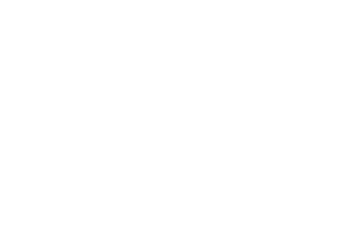

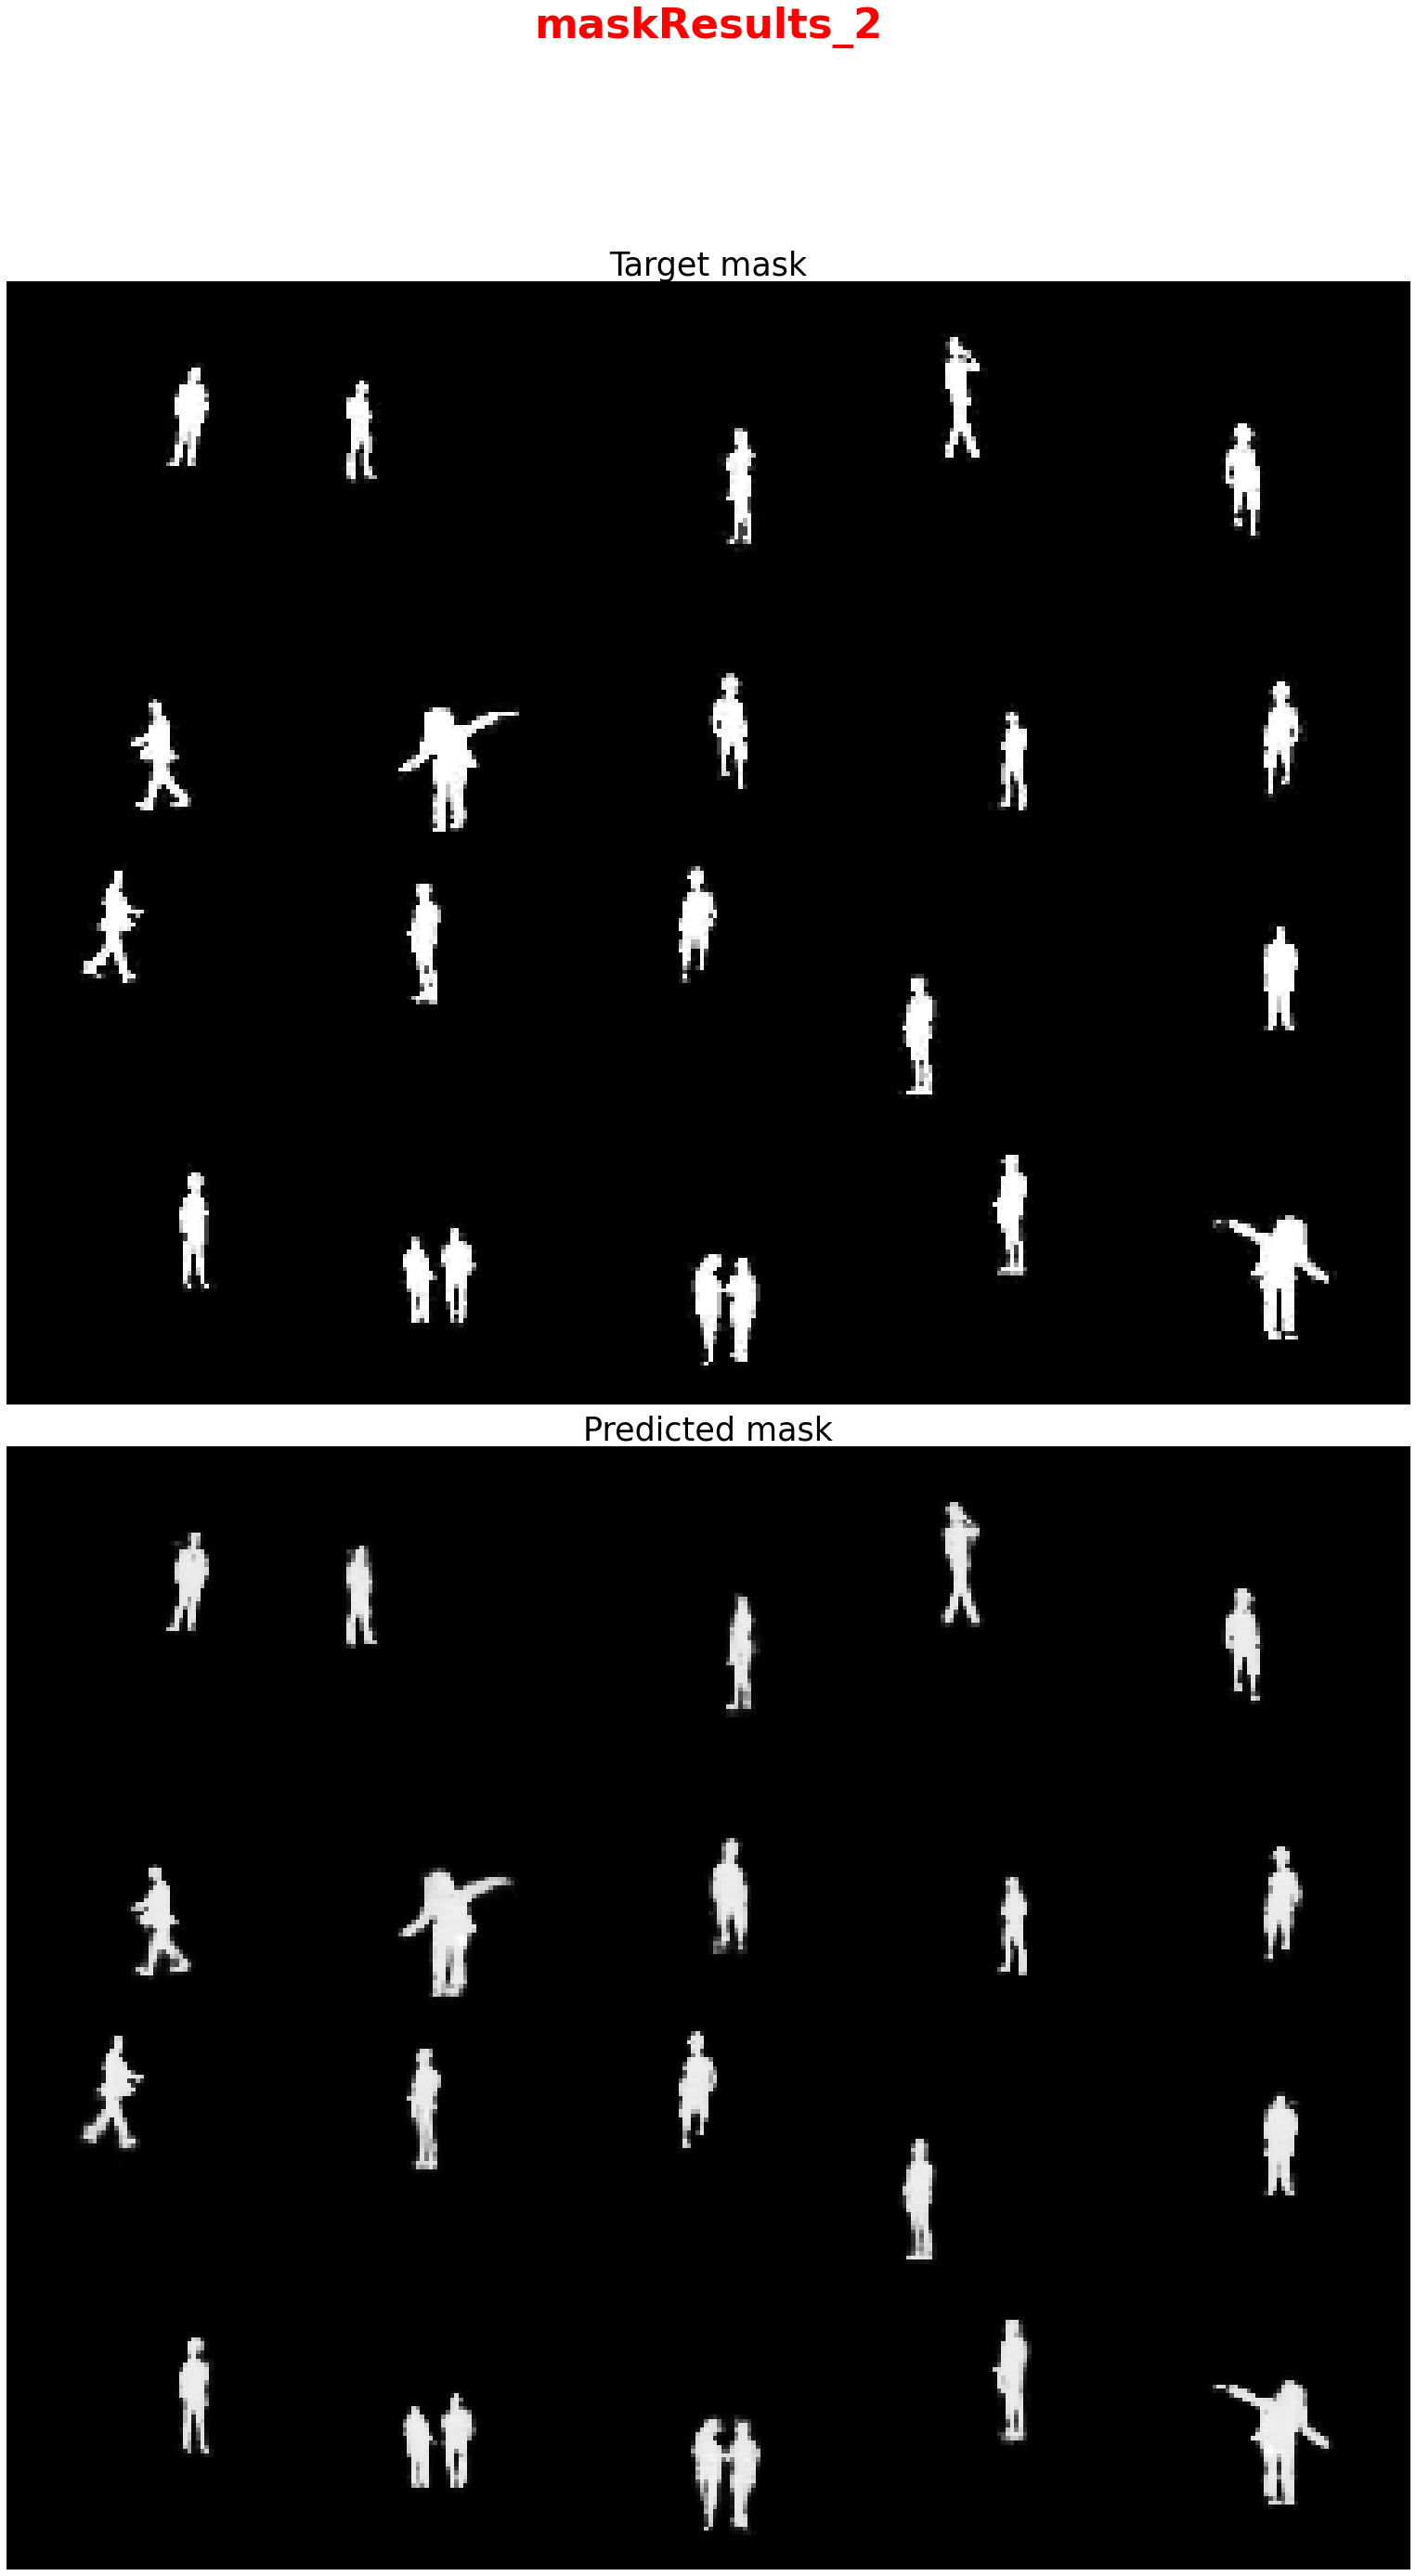

Results are saved in Results_2_ type.jpg


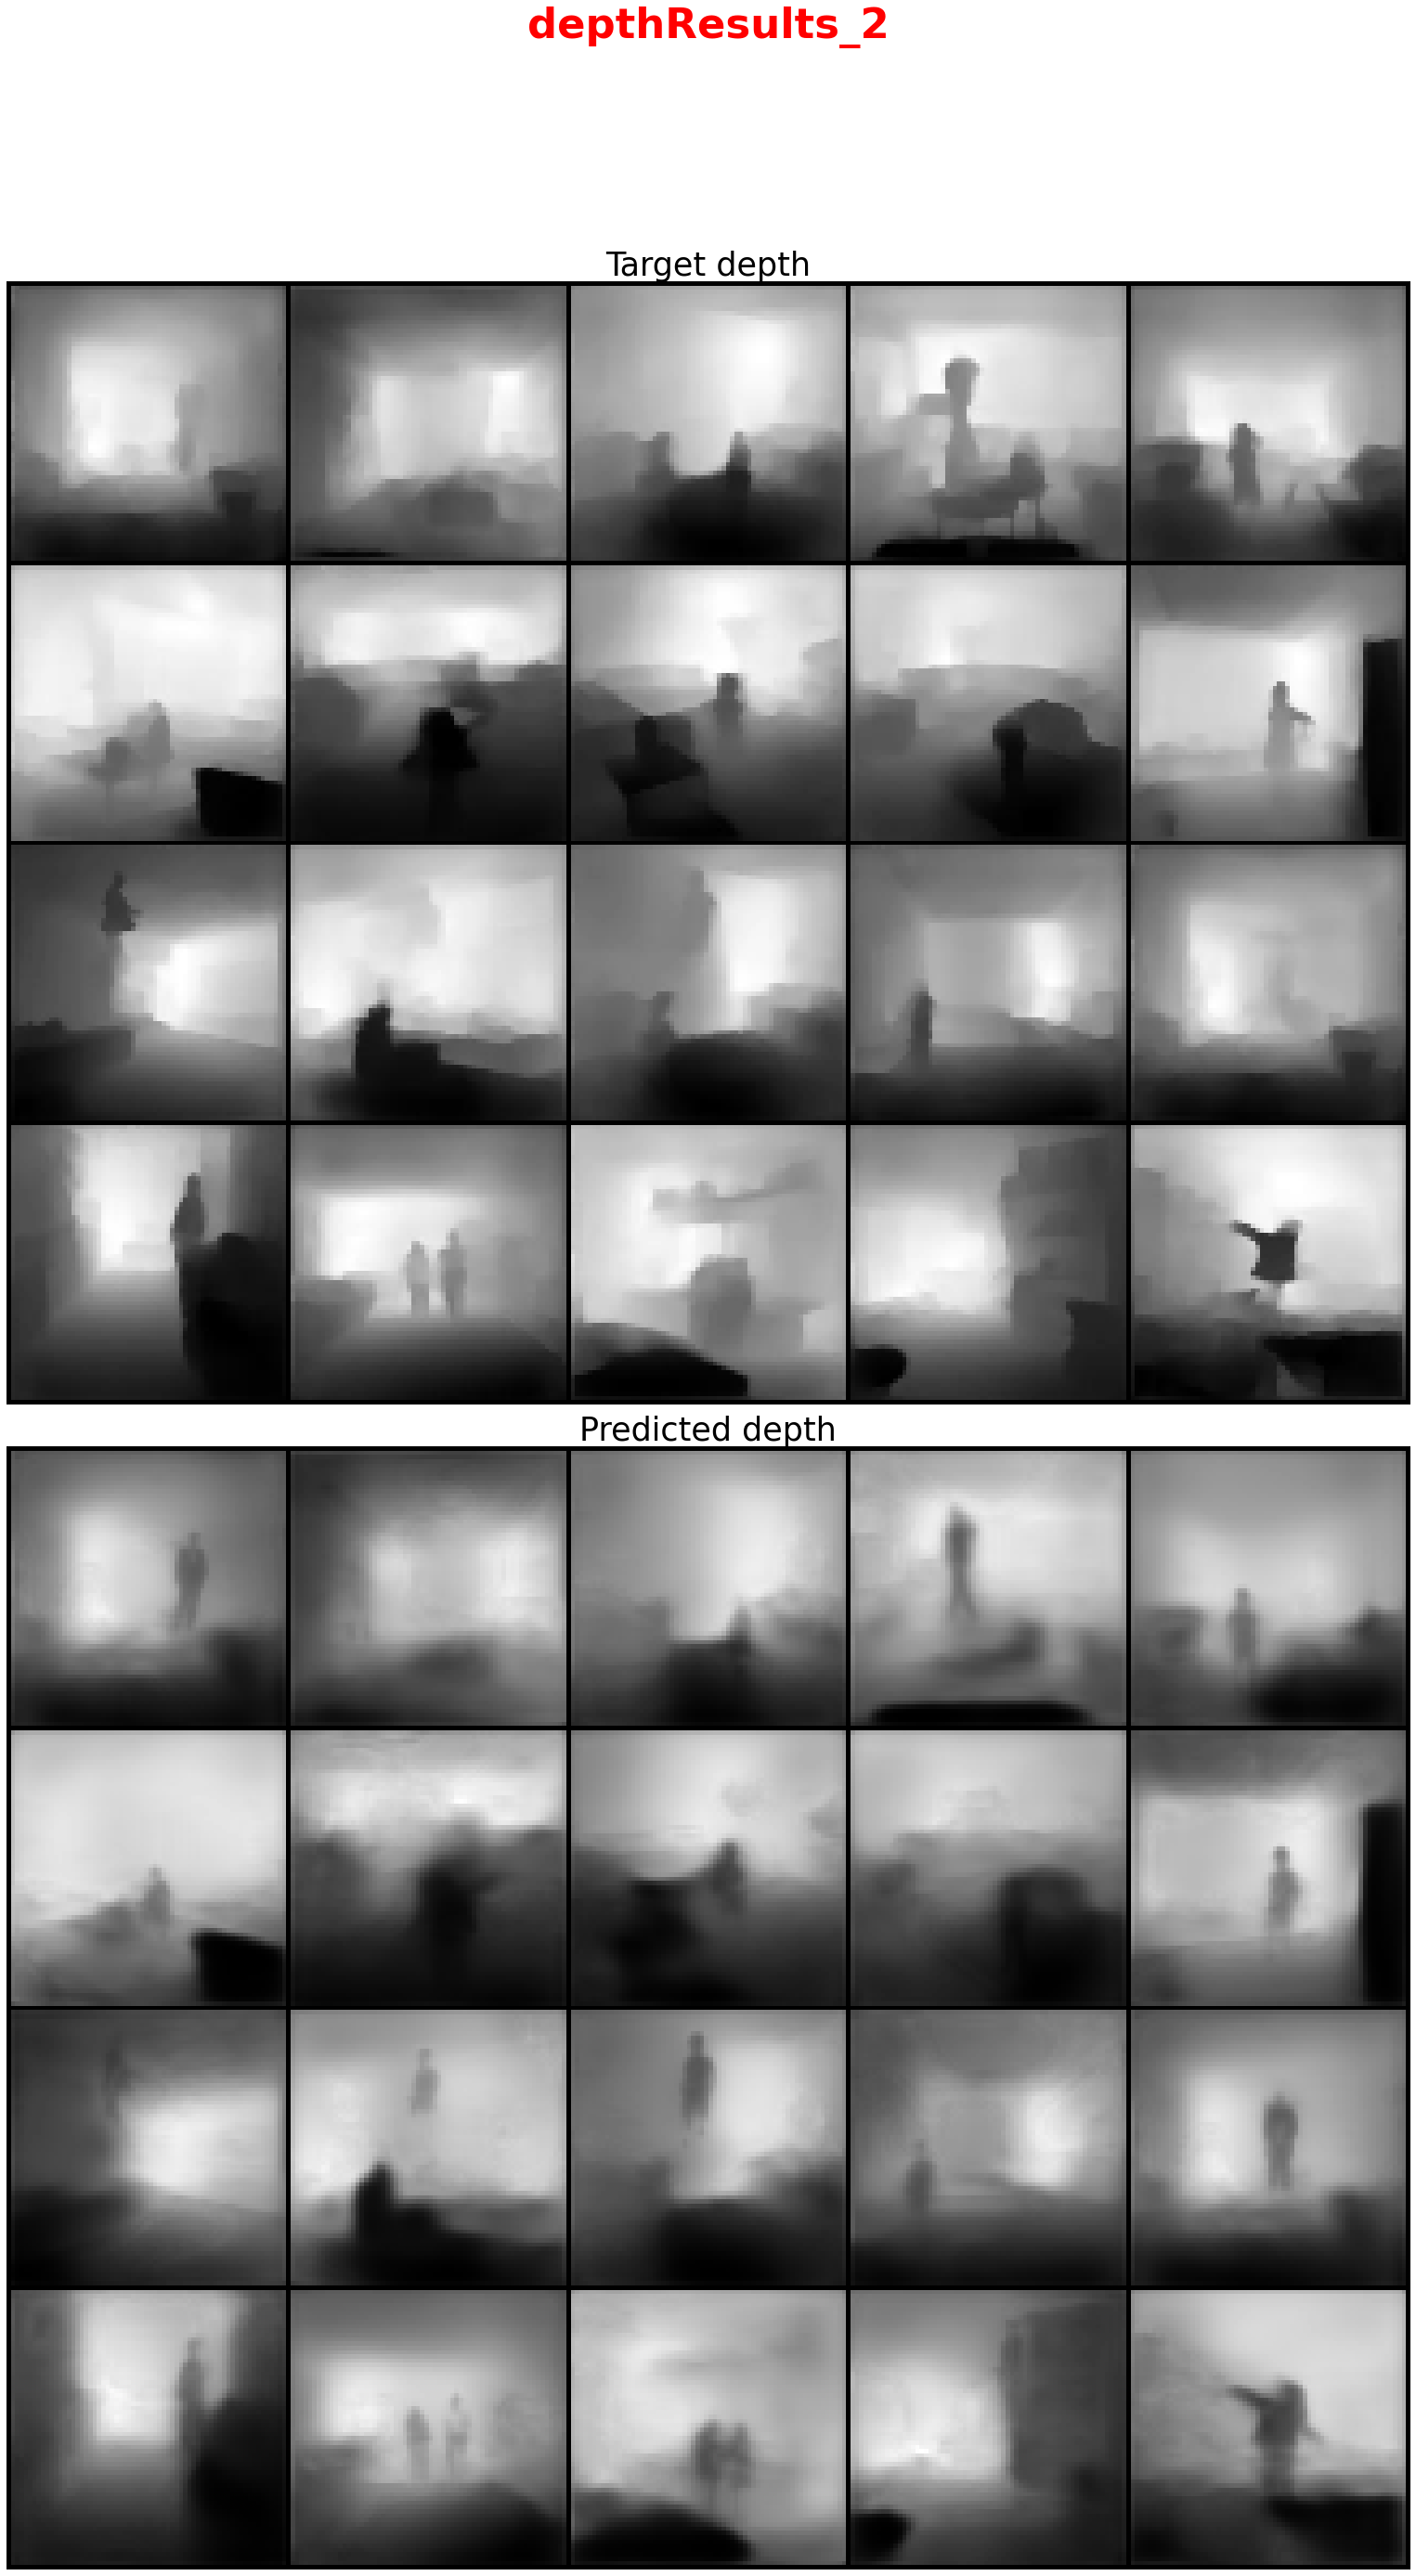

Results are saved in Results_2_ type.jpg


In [0]:
show_results(model,testloader, name = "Results_2")

# Set 3

In [0]:

start = time.time()
train_dataset , test_dataset= RawDataSet(train_split = 70,test_transforms=test,train_transforms=train, set_no = 3,url_path ='/content/data_3')
end = time.time()
print(f'dataset formation took {round(end-start,3)} seconds')


80000
dataset formation took 0.233 seconds


In [0]:
trainloader, testloader = train_test_loader.load(train_dataset,test_dataset,batch_size=128)

sample train images took 11.431s to dispay


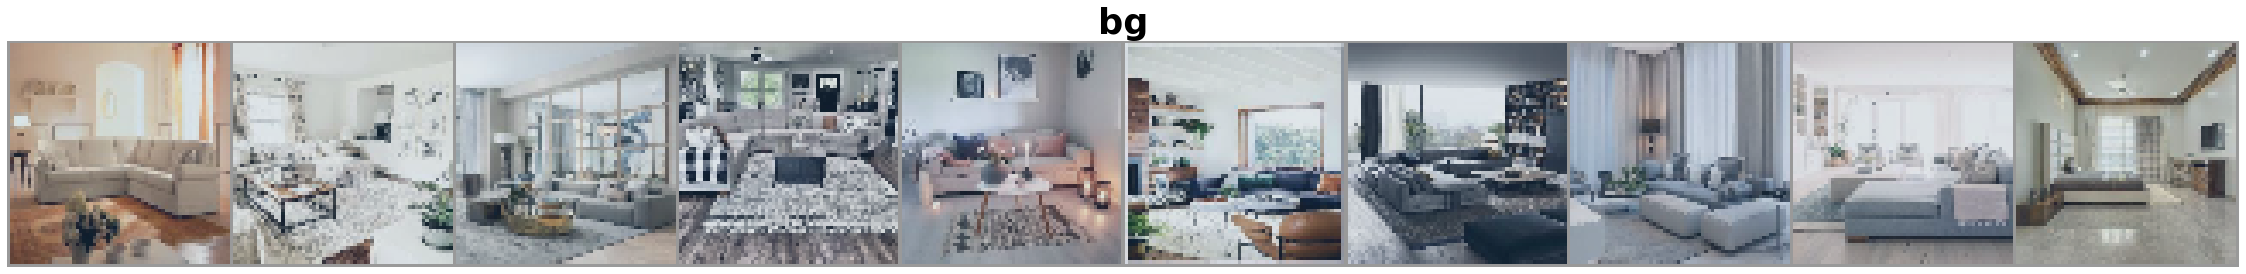

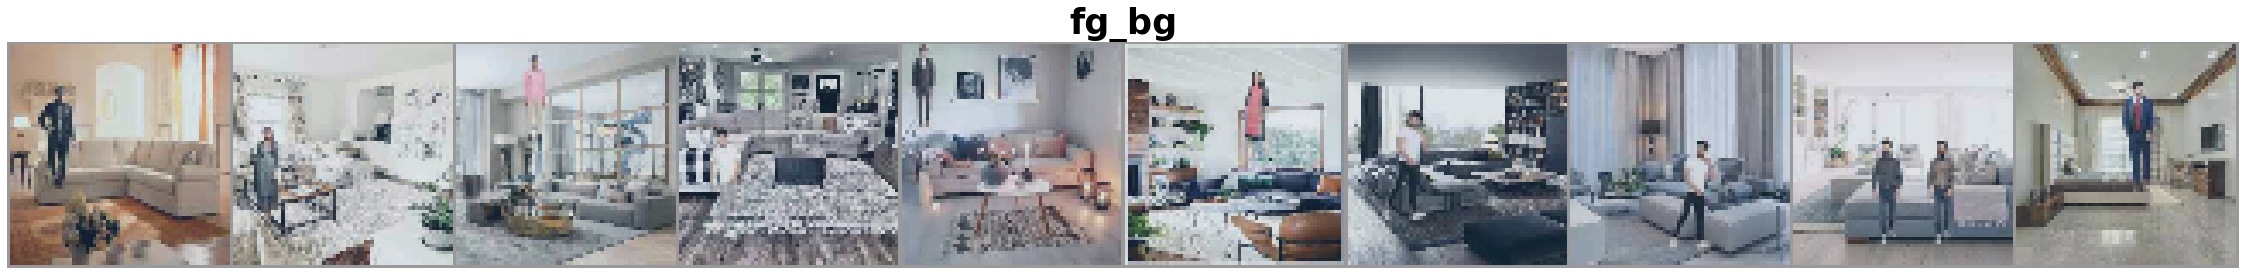

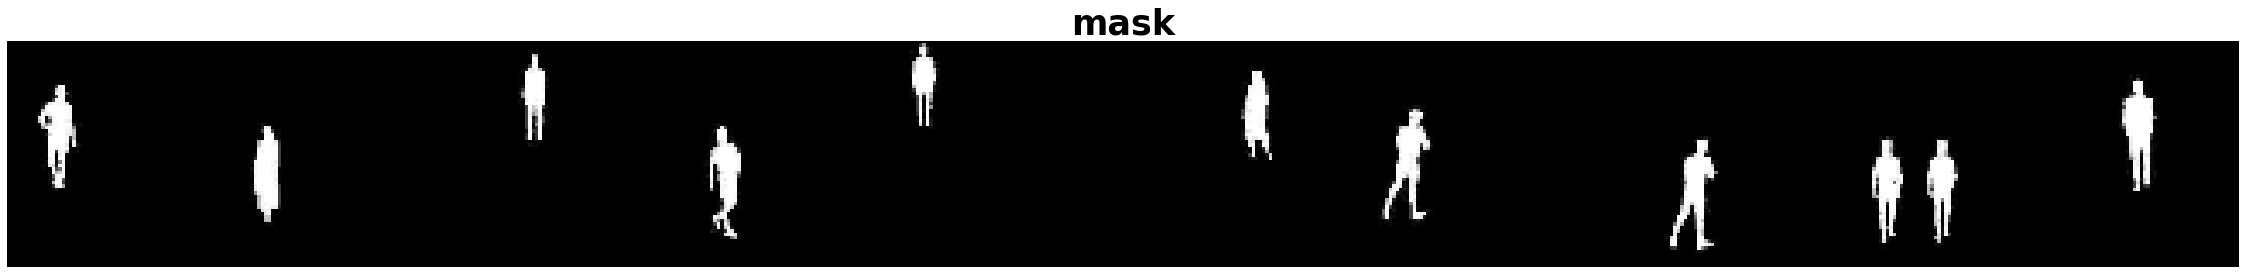

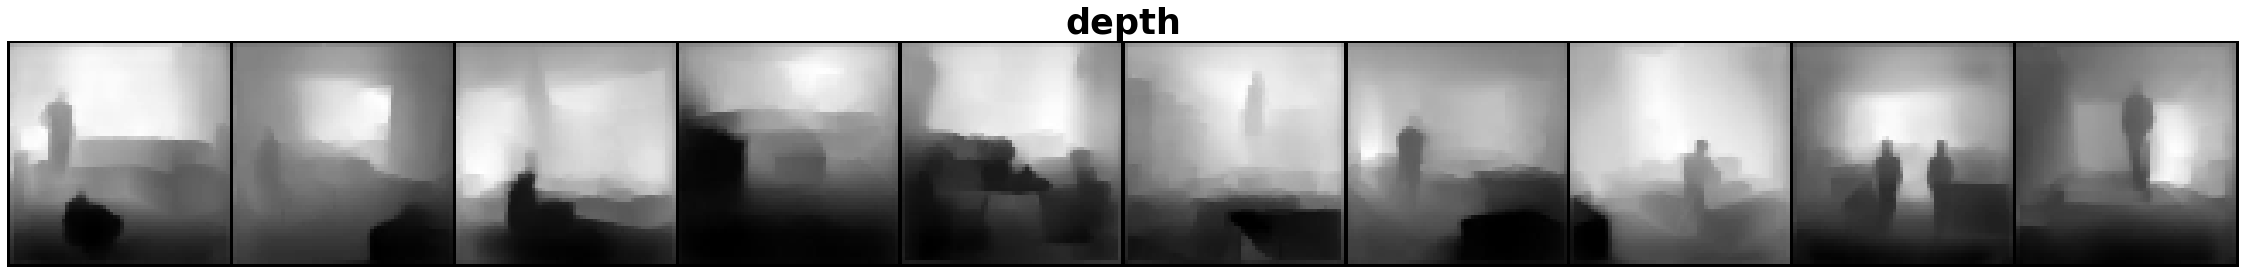

In [0]:
show_sample_data(trainloader)

In [0]:
model = UNet(n_channels = 6,n_classes = 1).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
checkpoint = torch.load("/content/gdrive/My Drive/S15-Checkpoints/checkpoint2.pt")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.eval()
print("Loaded the best model")

Loaded the best model


In [0]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR,StepLR

scheduler=optim.lr_scheduler.StepLR(optimizer,step_size = 4, gamma=0.1)

mask_criterion = nn.BCEWithLogitsLoss()
depth_criterion = nn.BCEWithLogitsLoss()


In [0]:
train_model(model,device,trainloader,testloader,optimizer,mask_criterion,depth_criterion,10,scheduler,batch_scheduler=False,best_loss = 0.0076,path = "/content/gdrive/My Drive/S15-Checkpoints/checkpoint3.pt")

EPOCH: 1 LR: 0.01




Train set: Average loss: 0.0075, Coef: (0.00307)





Test set: Average loss: 0.0076, Coef: (0.00309)

loss reduced, Saving model....
----------------------------------------------------------------------------------
EPOCH: 2 LR: 0.01




Train set: Average loss: 0.0074, Coef: (0.00303)





Test set: Average loss: 0.0076, Coef: (0.00284)

----------------------------------------------------------------------------------
EPOCH: 3 LR: 0.01




Train set: Average loss: 0.0075, Coef: (0.00302)





Test set: Average loss: 0.0076, Coef: (0.00305)

----------------------------------------------------------------------------------
EPOCH: 4 LR: 0.01




Train set: Average loss: 0.0078, Coef: (0.00306)





Test set: Average loss: 0.0076, Coef: (0.00307)

loss reduced, Saving model....
----------------------------------------------------------------------------------
EPOCH: 5 LR: 0.001




Train set: Average loss: 0.0078, Coef: (0.00307)





Test set: Average loss: 0.0076, Coef: (0.00306)

loss reduced, Saving model....
----------------------------------------------------------------------------------
EPOCH: 6 LR: 0.001




Train set: Average loss: 0.0077, Coef: (0.00307)





Test set: Average loss: 0.0076, Coef: (0.00309)

----------------------------------------------------------------------------------
EPOCH: 7 LR: 0.001




Train set: Average loss: 0.0076, Coef: (0.00307)





Test set: Average loss: 0.0076, Coef: (0.00307)

loss reduced, Saving model....
----------------------------------------------------------------------------------
EPOCH: 8 LR: 0.001




Train set: Average loss: 0.0075, Coef: (0.00307)





Test set: Average loss: 0.0076, Coef: (0.00308)

----------------------------------------------------------------------------------
EPOCH: 9 LR: 0.0001




Train set: Average loss: 0.0075, Coef: (0.00308)





Test set: Average loss: 0.0076, Coef: (0.00308)

loss reduced, Saving model....
----------------------------------------------------------------------------------
EPOCH: 10 LR: 0.0001




Train set: Average loss: 0.0076, Coef: (0.00308)





Test set: Average loss: 0.0076, Coef: (0.00307)

----------------------------------------------------------------------------------
Traning took 2853.316s for 10 epochs


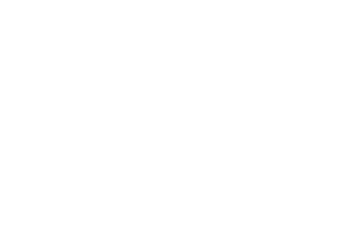

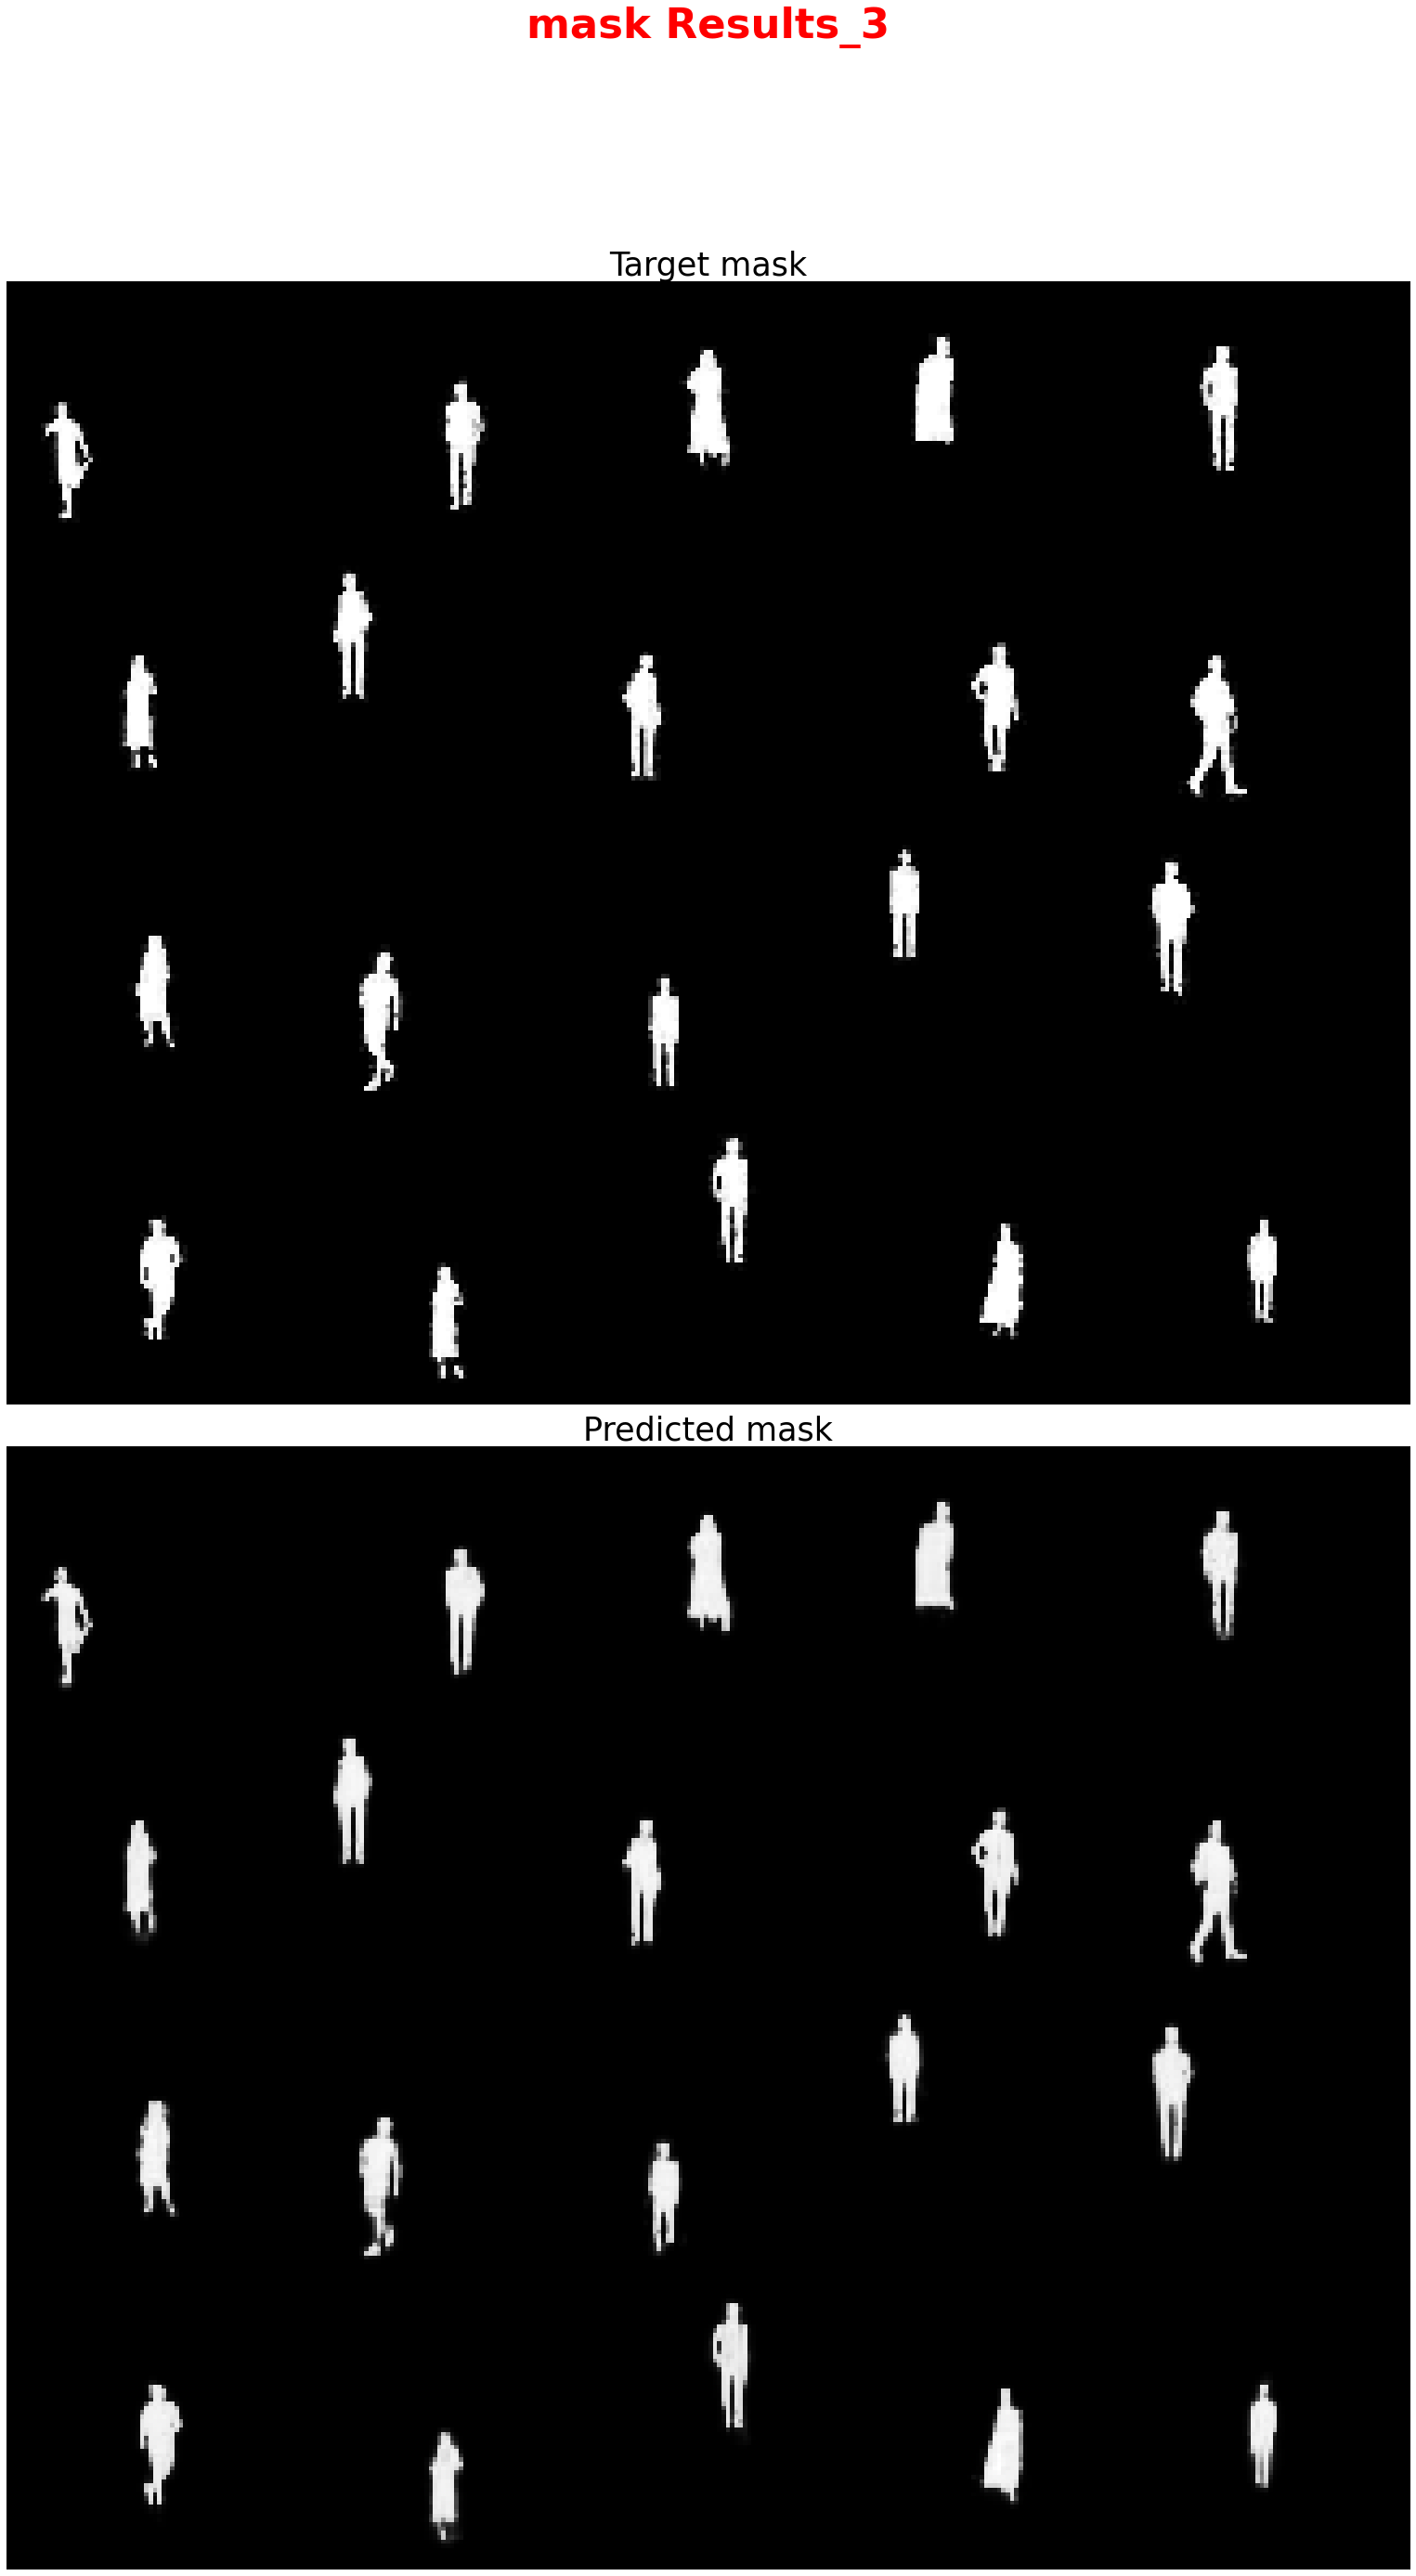

Results are saved in Results_3_ type.jpg


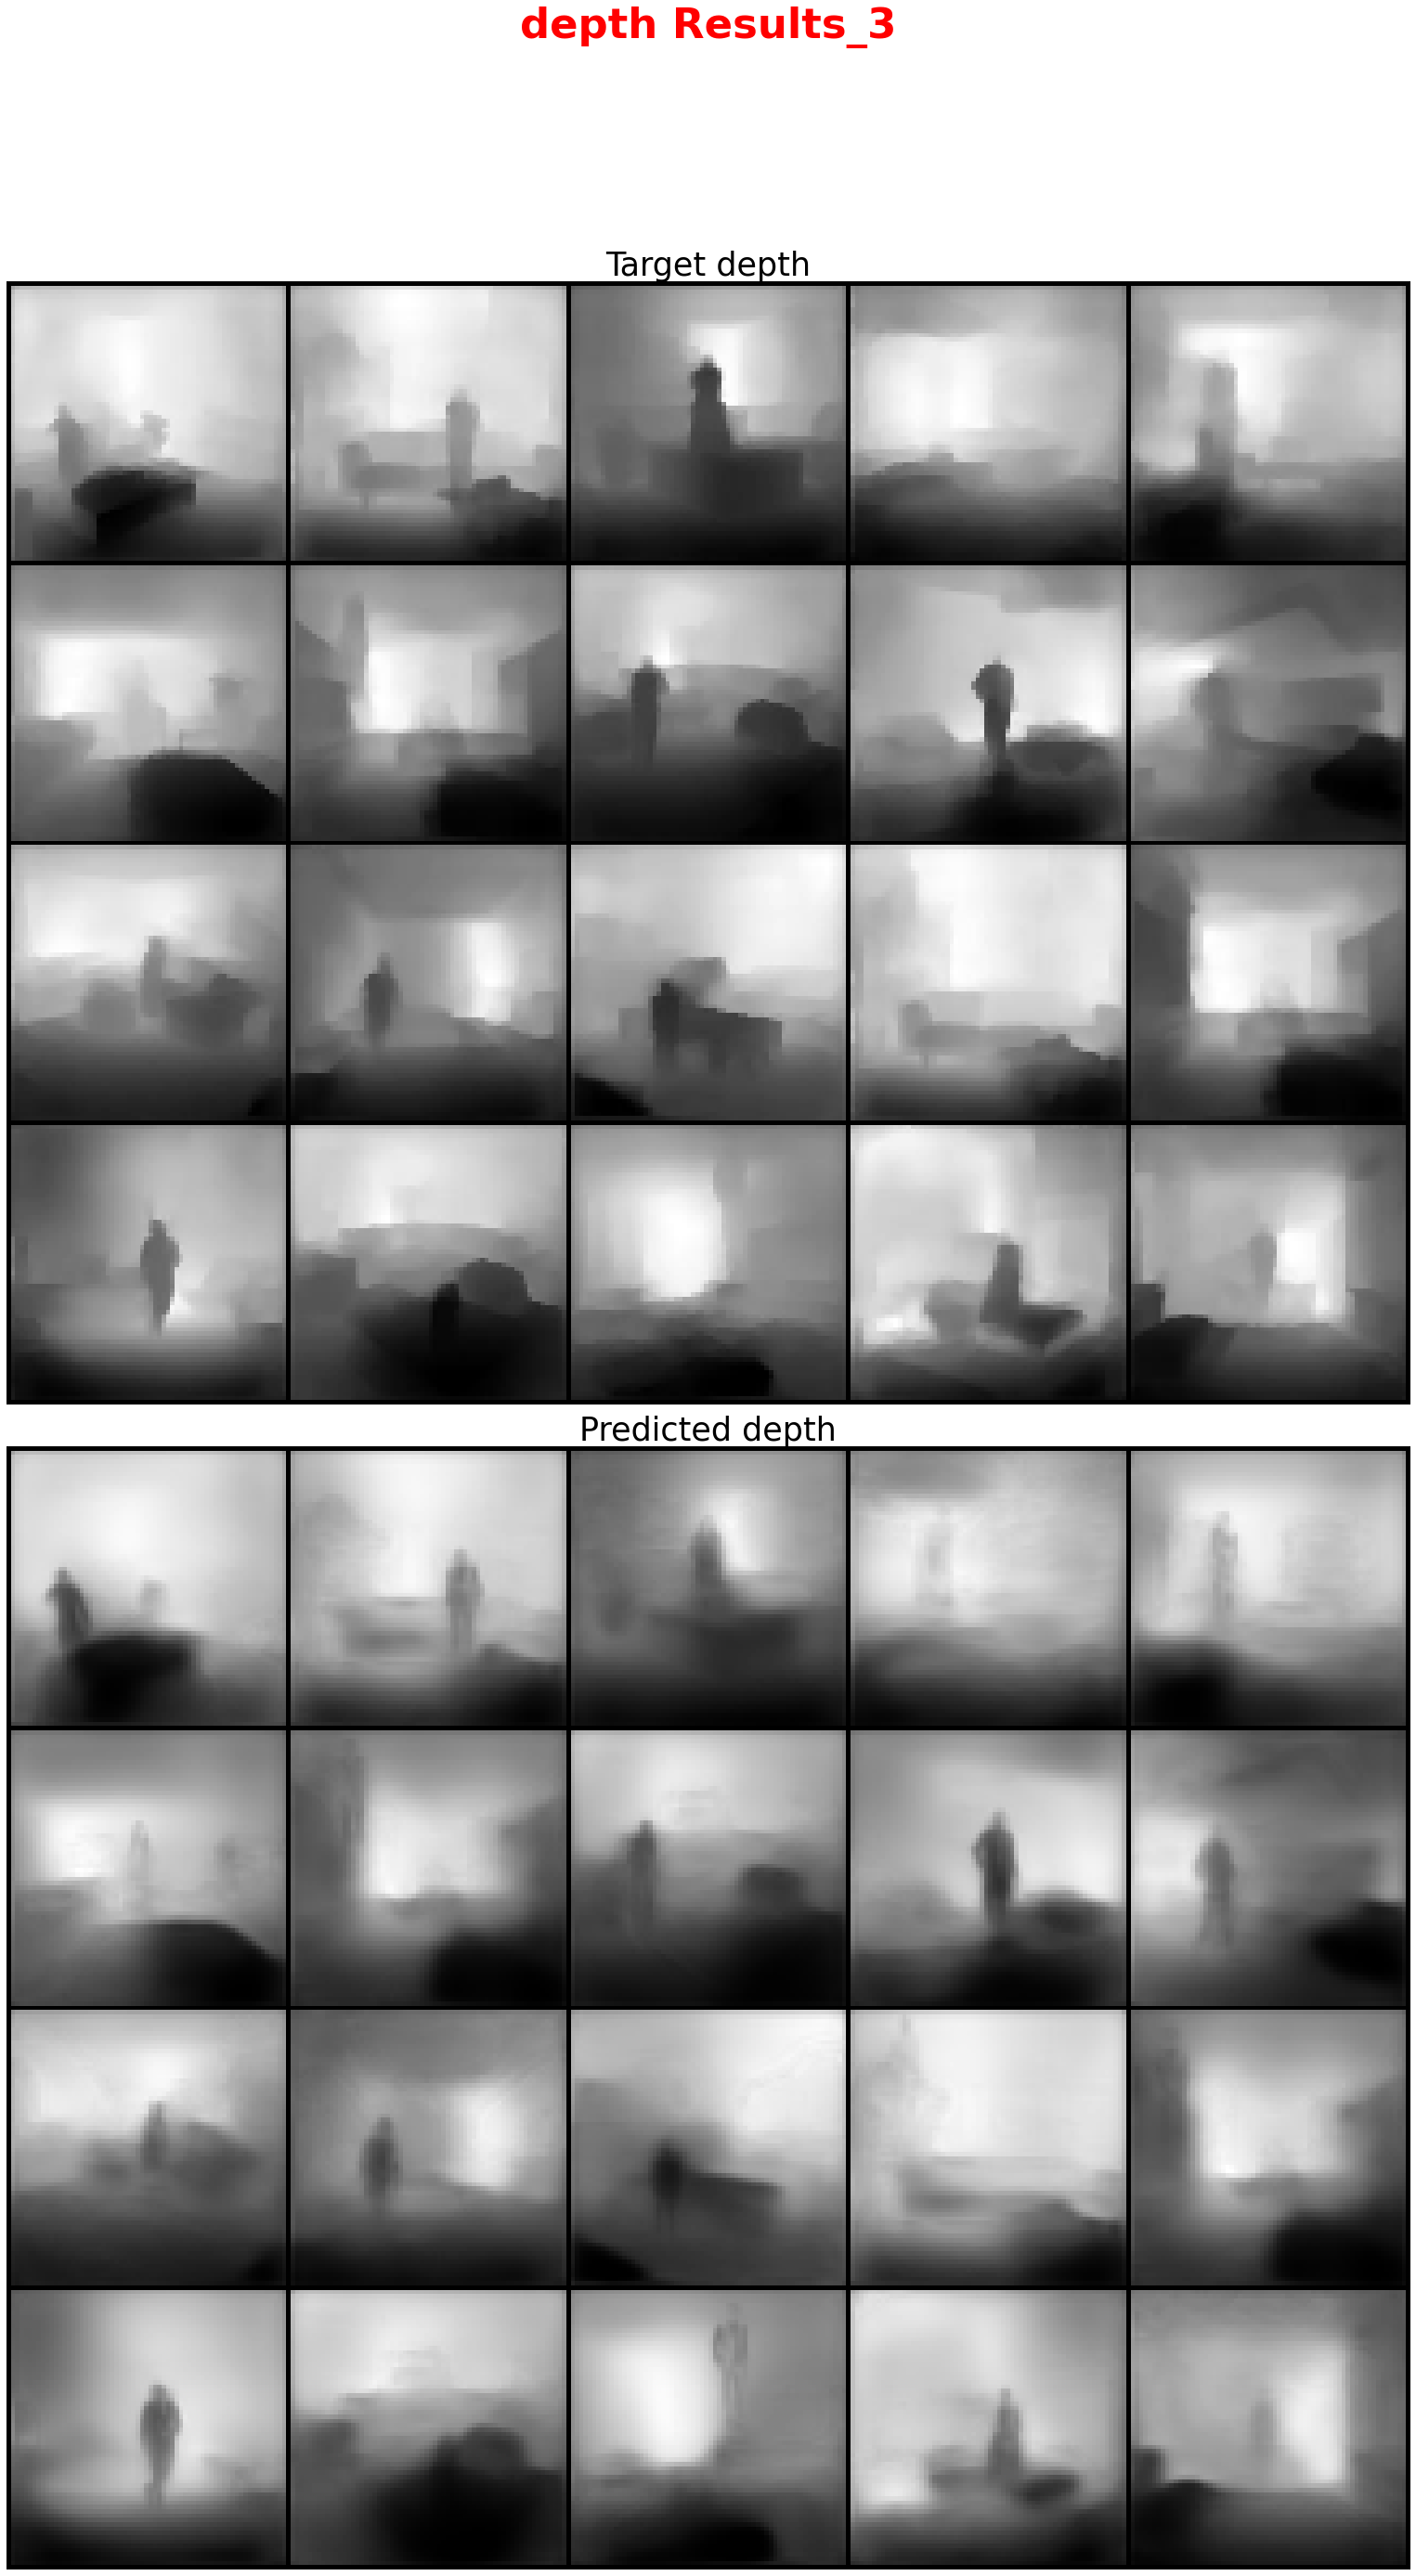

Results are saved in Results_3_ type.jpg


In [0]:
show_results(model,testloader, name = "Results_3")

# Set 4

In [0]:
start = time.time()
train_dataset , test_dataset= RawDataSet(train_split = 70,test_transforms=test,train_transforms=train, set_no = 4,url_path ='/content/data_4')
end = time.time()
print(f'dataset formation took {round(end-start,3)} seconds')


80000
dataset formation took 0.228 seconds


In [0]:
trainloader, testloader = train_test_loader.load(train_dataset,test_dataset,batch_size=128)

sample train images took 1.879s to dispay


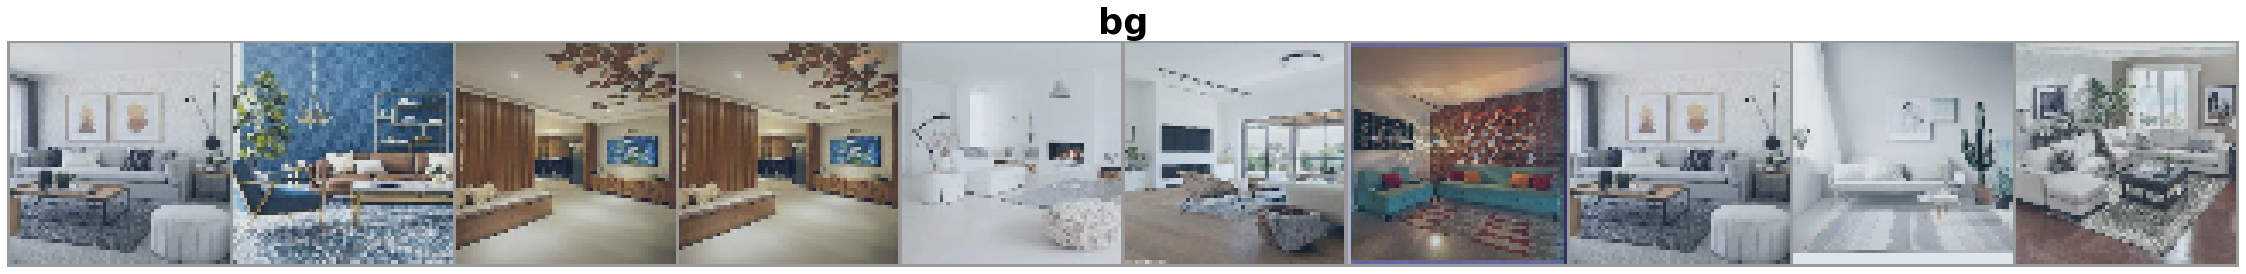

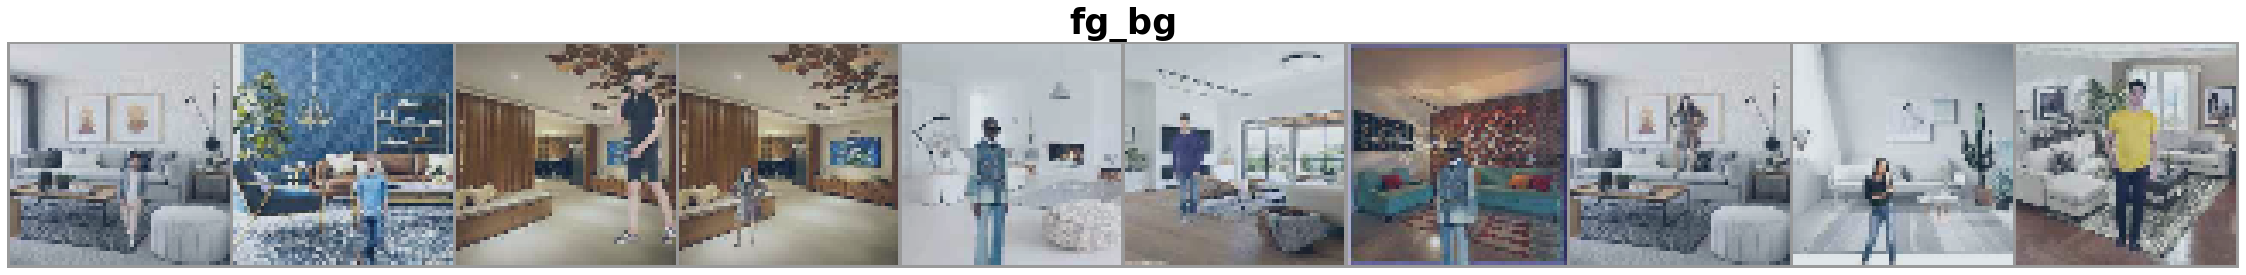

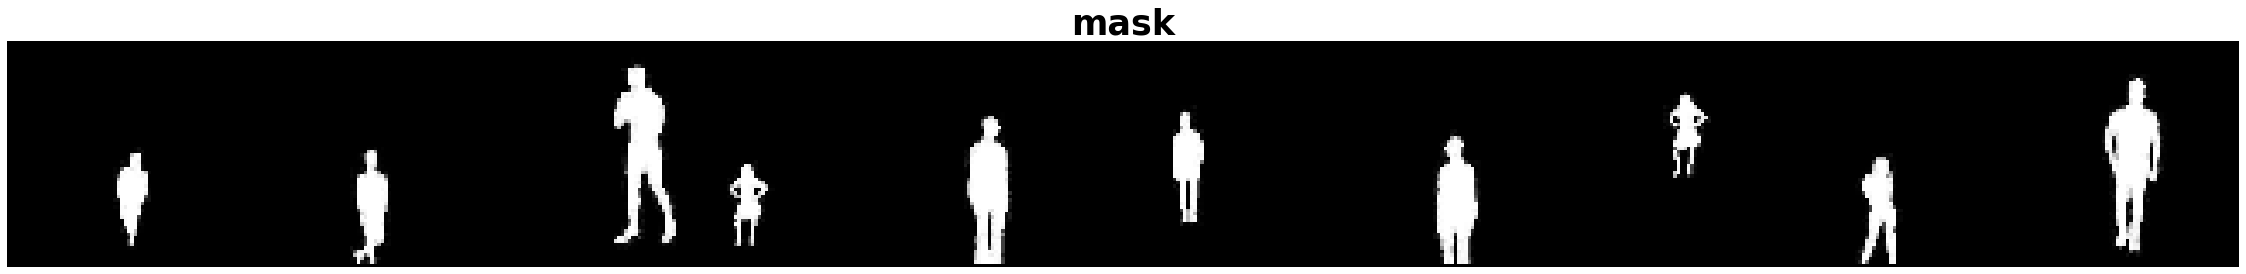

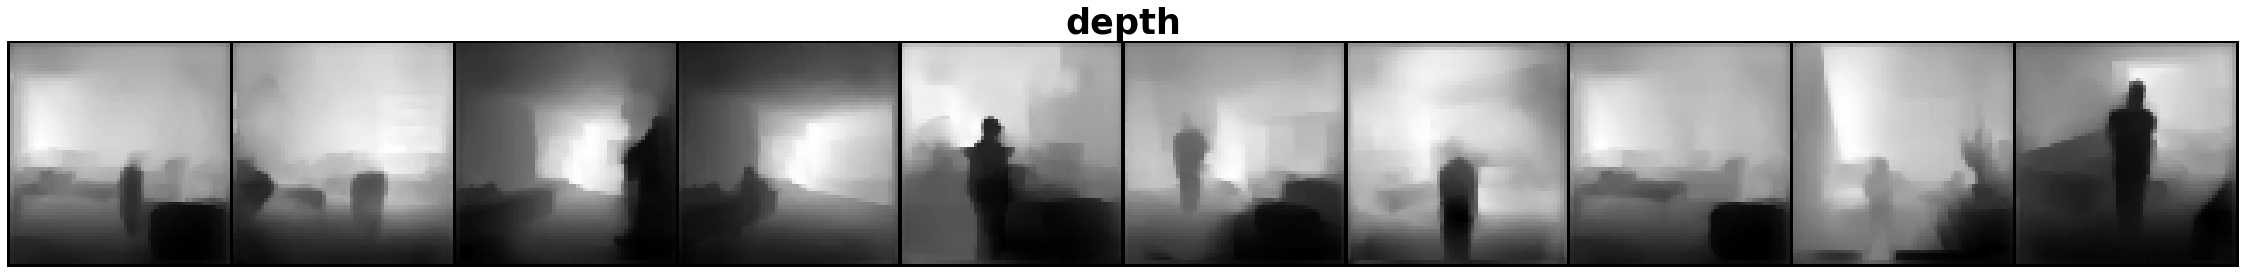

In [0]:
show_sample_data(trainloader)

In [0]:
model = UNet(n_channels = 6,n_classes = 1).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
checkpoint = torch.load("/content/gdrive/My Drive/S15-Checkpoints/checkpoint3.pt")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.eval()
print("Loaded the best model")

Loaded the best model


In [0]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR,StepLR

scheduler=optim.lr_scheduler.StepLR(optimizer,step_size = 4, gamma=0.1)

mask_criterion = nn.BCEWithLogitsLoss()
depth_criterion = nn.BCEWithLogitsLoss()


In [0]:
train_model(model,device,trainloader,testloader,optimizer,mask_criterion,depth_criterion,10,scheduler,batch_scheduler=False,best_loss = 0.0076,path = "/content/gdrive/My Drive/S15-Checkpoints/checkpoint4.pt")

EPOCH: 1 LR: 0.0001




Train set: Average loss: 0.0077, Coef: (0.00306)





Test set: Average loss: 0.0077, Coef: (0.00307)

----------------------------------------------------------------------------------
EPOCH: 2 LR: 0.0001




Train set: Average loss: 0.0078, Coef: (0.00307)





Test set: Average loss: 0.0077, Coef: (0.00307)

----------------------------------------------------------------------------------
EPOCH: 3 LR: 0.0001




Train set: Average loss: 0.0077, Coef: (0.00307)





Test set: Average loss: 0.0077, Coef: (0.00306)

----------------------------------------------------------------------------------
EPOCH: 4 LR: 0.0001




Train set: Average loss: 0.0076, Coef: (0.00307)





Test set: Average loss: 0.0077, Coef: (0.00307)

----------------------------------------------------------------------------------
EPOCH: 5 LR: 1e-05




Train set: Average loss: 0.0079, Coef: (0.00307)





Test set: Average loss: 0.0077, Coef: (0.00307)

----------------------------------------------------------------------------------
EPOCH: 6 LR: 1e-05




Train set: Average loss: 0.0076, Coef: (0.00307)





Test set: Average loss: 0.0077, Coef: (0.00307)

----------------------------------------------------------------------------------
EPOCH: 7 LR: 1e-05




Train set: Average loss: 0.0078, Coef: (0.00307)





Test set: Average loss: 0.0077, Coef: (0.00308)

----------------------------------------------------------------------------------
EPOCH: 8 LR: 1e-05




Train set: Average loss: 0.0076, Coef: (0.00307)





Test set: Average loss: 0.0077, Coef: (0.00307)

----------------------------------------------------------------------------------
EPOCH: 9 LR: 1.0000000000000002e-06




Train set: Average loss: 0.0078, Coef: (0.00307)





Test set: Average loss: 0.0077, Coef: (0.00307)

----------------------------------------------------------------------------------
EPOCH: 10 LR: 1.0000000000000002e-06




Train set: Average loss: 0.0077, Coef: (0.00307)



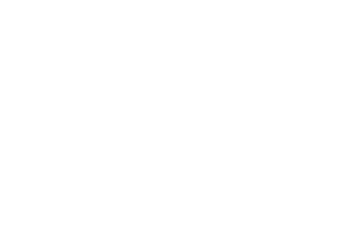

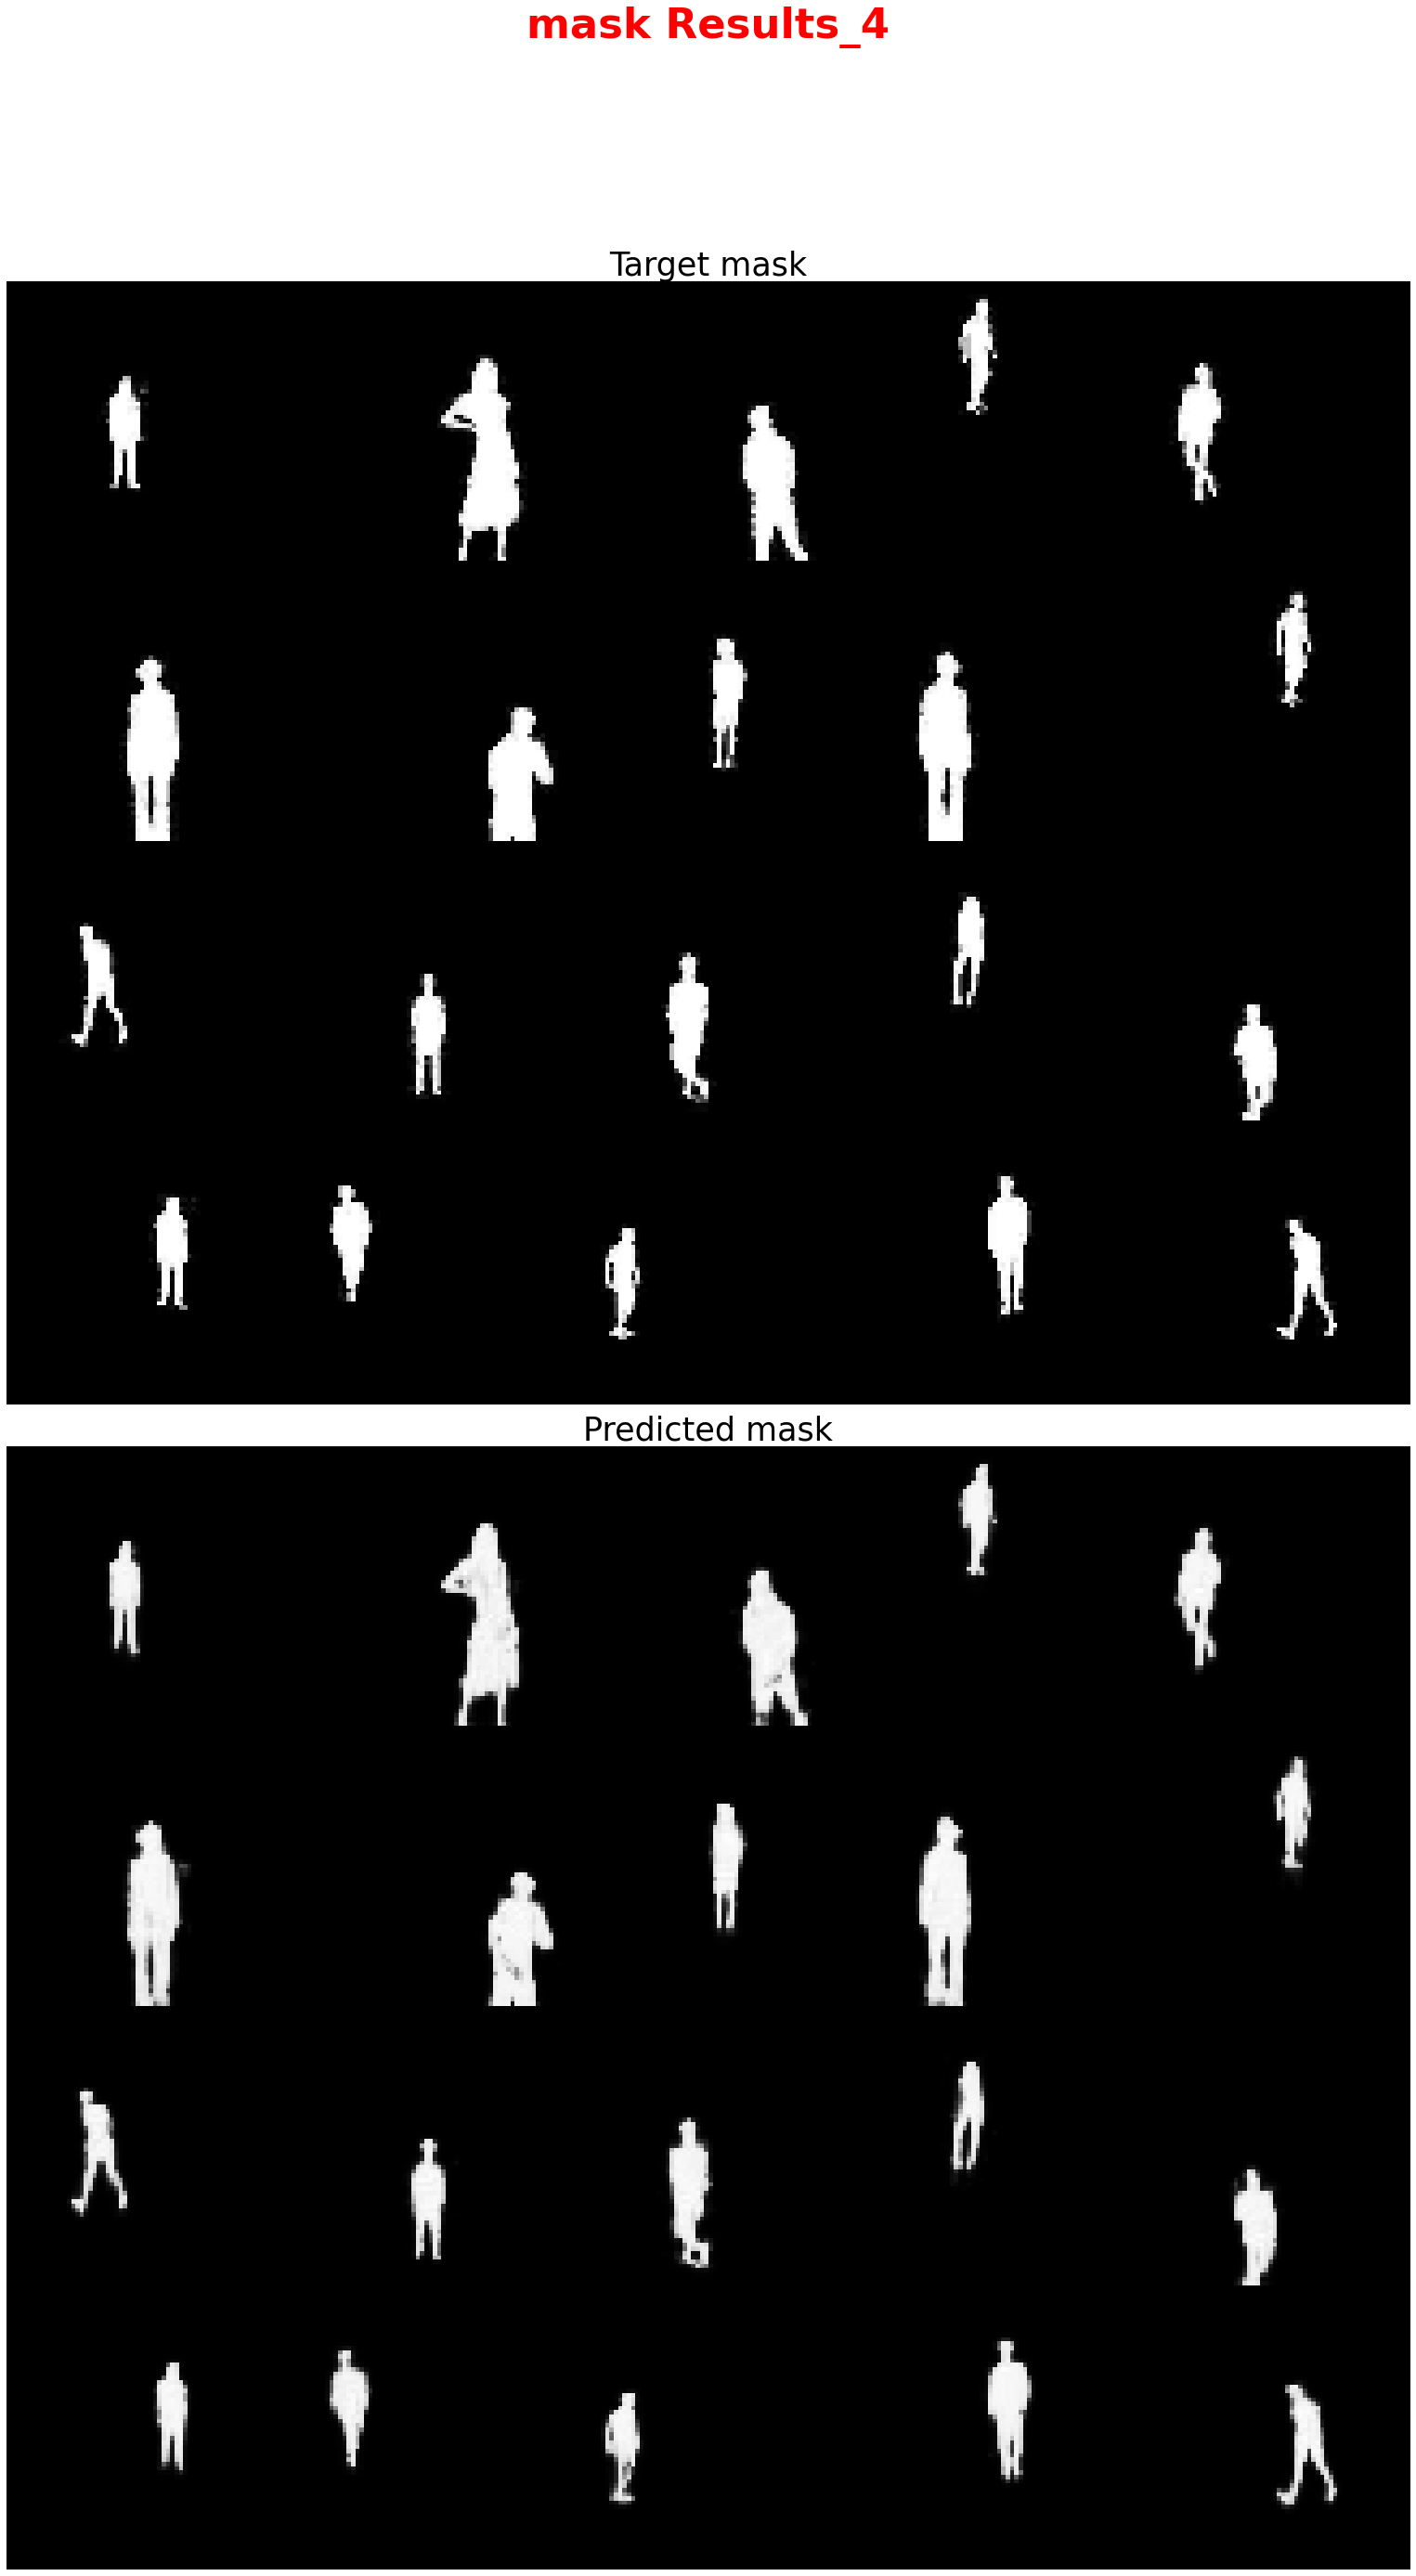

Results are saved in Results_4_ type.jpg


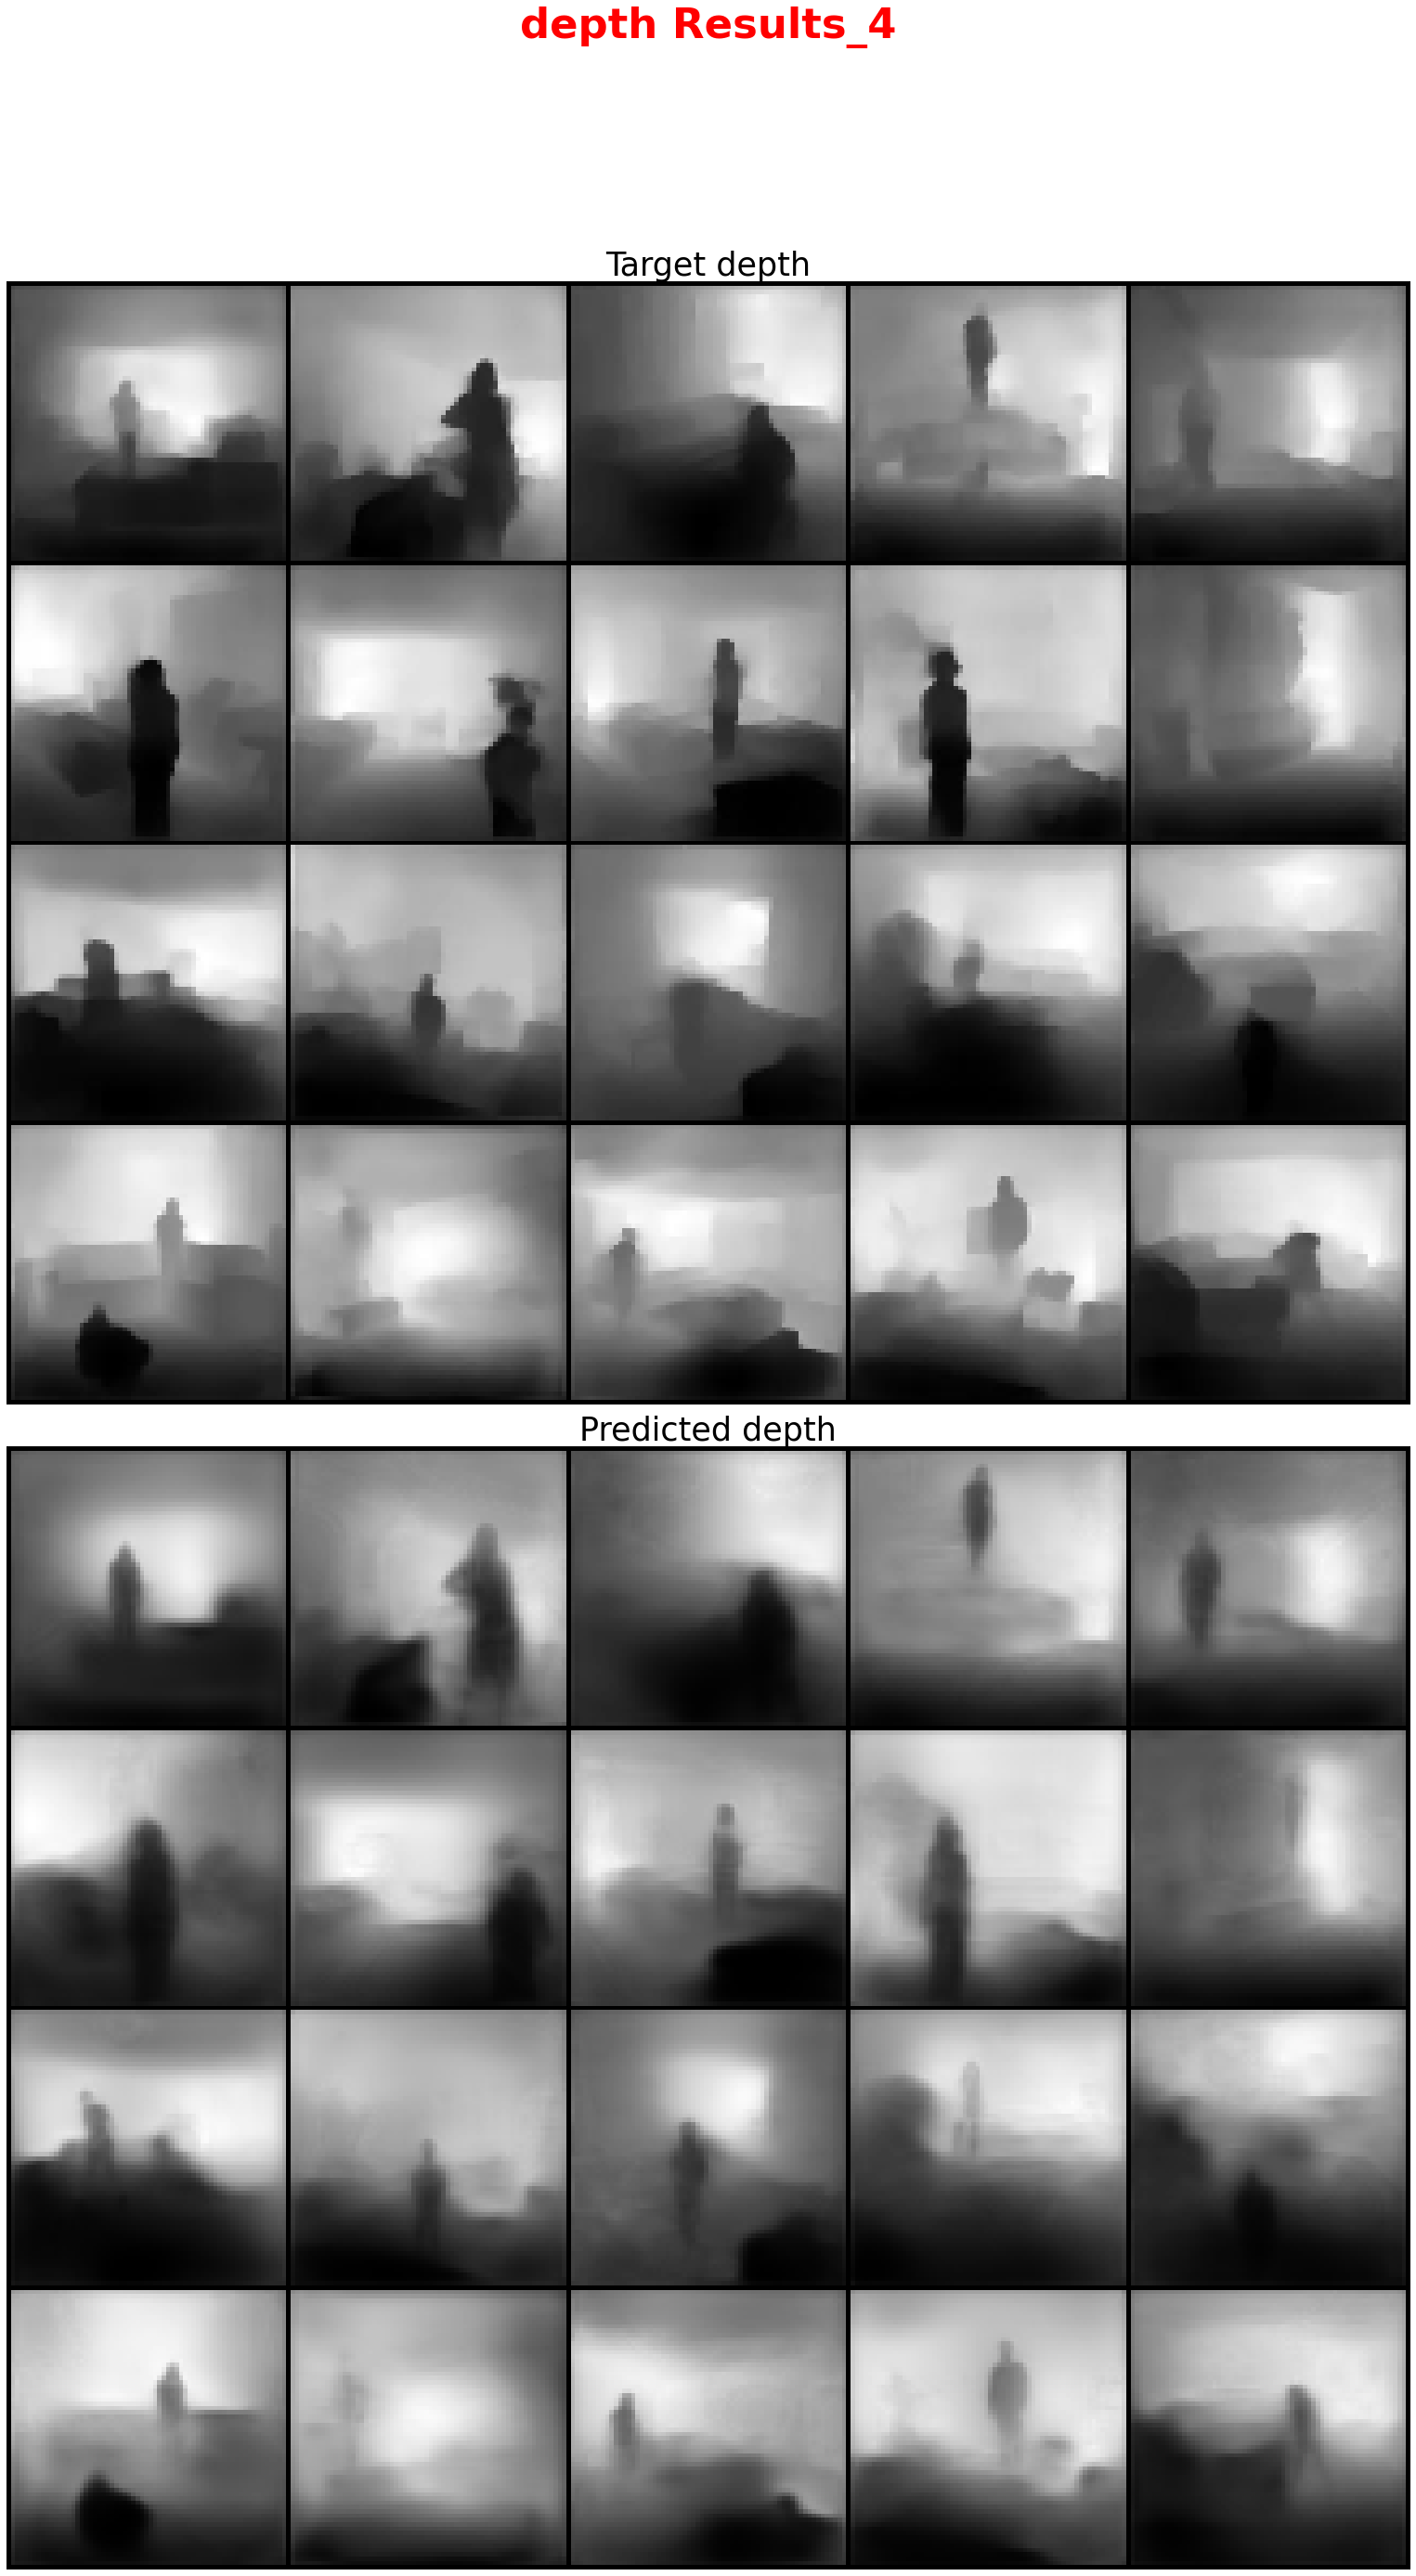

Results are saved in Results_4_ type.jpg


In [0]:
show_results(model,testloader, name = "Results_4")

# Set 5


Unfortunately results were not displayed when I copy to git. But trained for 5th set as well

In [0]:
start = time.time()
train_dataset , test_dataset= RawDataSet(train_split = 70,test_transforms=test,train_transforms=train, set_no = 5,url_path ='/content/data_5')
end = time.time()
print(f'dataset formation took {round(end-start,3)} seconds')

In [0]:
trainloader, testloader = train_test_loader.load(train_dataset,test_dataset,batch_size=128)

In [0]:
show_sample_data(trainloader)

In [0]:
model = UNet(n_channels = 6,n_classes = 1).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
checkpoint = torch.load("/content/gdrive/My Drive/S15-Checkpoints/checkpoint4.pt")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.eval()
print("Loaded the best model")

In [0]:
import torchvision
from torch.utils.tensorboard import SummaryWriter
tb = SummaryWriter('runs/MODEST-5')
images, mask, depth = next(iter(trainloader))
images = images.to(device)

#tb.add_image('images', images)
tb.add_graph(model, images)
tb.close()

In [0]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR,StepLR

scheduler=optim.lr_scheduler.StepLR(optimizer,step_size = 4, gamma=0.1)

mask_criterion = nn.BCEWithLogitsLoss()
depth_criterion = nn.BCEWithLogitsLoss()


In [0]:
train_model(model,device,trainloader,testloader,optimizer,mask_criterion,depth_criterion,10,scheduler,batch_scheduler=False,best_loss = 0.0076,path = "/content/gdrive/My Drive/S15-Checkpoints/checkpoint5.pt")

In [0]:
show_results(model,testloader, name = "Results_5")